In [24]:
import os
import random
import numpy as np
import cv2
import json


from pathlib import Path
from pylab import imread
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from skimage.transform import rescale, resize
from skimage import measure
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries
from skimage.morphology import (erosion, dilation, opening, closing, white_tophat)
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
from scipy import ndimage
from tqdm import tqdm

Useful Function

In [25]:
def connect_to_data_folder(folder_path: Path) -> None:
    print('>>>>> Begin Connecting to Data Folder <<<<<')

    if os.path.isdir(folder_path):
        os.chdir(folder_path)
        print(f'List of files in {folder_path}:')
        display(os.listdir())

    else:
        print(f'Folder {folder_path} does not exist')

    print('>>>>> End Connecting to Data Folder <<<<<')
    return None


def get_sub_files(dir: Path, extension_list: list = []) -> list:
    print('>>>>> Begin Getting Sub Files <<<<<')

    # Get a list of immediate subfiles
    all_file_names = next(os.walk(dir))[2]
    subfile_names = list()

    if extension_list:
        for filename in all_file_names:
            name, extension = os.path.splitext(filename)

            if any(ext in extension for ext in extension_list):
                subfile_names.append(f'{dir}/{filename}')
    else:
        subfile_names = [f'{dir}/{x}' for x in all_file_names]

    if len(subfile_names) == 1:
        print(f'There is {len(subfile_names)} file are found')
    else:
        print(f'There are {len(subfile_names)} files are found')

    print('Here is some samples :')
    [print(x) for x in subfile_names[0: min(len(subfile_names), 5)]]

    print('>>>>> End Getting Sub Files <<<<<')
    return subfile_names

def show_images(images: list, n_rows: int = 1, n_cols: int = 2, titles: list = []) -> None:
    gs = gridspec.GridSpec(n_rows, n_cols)

    plt.figure(figsize=(20, 20))

    for i, image in enumerate(images):
        ax = plt.subplot(gs[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        plt.subplot(n_rows, n_cols, i+1)

        if(len(image.shape) < 3):
            plt.imshow(image, cmap='gray')
        else:
            image = np.uint8(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image)

        if len(titles) > 0:
            plt.title(f'{titles[i]}')
        else:
            plt.title(f'Image {i+1}')
        plt.axis('off')

    plt.show()
    return None

def show_random_images(dataset, n_rows: int = 1, n_cols: int = 5, seed_no: int = 24):
    print(f'>>>>> Begin Showing Random Images <<<<<')

    num_files = n_rows * n_cols
    random.seed(seed_no)
    random_files = random.sample(dataset, num_files)

    images = [cv2.imread(file) for file in random_files]
    show_images(images, n_rows=n_rows, n_cols=n_cols)

    print(f'>>>>> End Showing Random Images <<<<<')
    return images, random_files

def resize_image(image: np.ndarray, target_height: int = 1, target_width: int = 1) -> np.ndarray:
    if target_height > 0 and target_width > 0:
        resized_image = rescale(image, (target_height / image.shape[0],
                                        target_width / image.shape[1]),
                                interpolation=cv2.INTER_NEAREST)
    else:
        resized_image = image

    return resized_image

def convert_color_spaces(image, color_space='gray', display=True):
    channel_names = ['Origin Image']
    match color_space.lower():
        case 'gray':
            image_convert = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        case 'hsv':
            image_convert = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            channel_names.extend([f'{color_space.upper()} Converted Image', "Chrominance Hue" , "Chrominance Saturation", "Luminance Value"])
        case 'ycrcb':
            image_convert = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
            channel_names.extend([f'{color_space.upper()} Converted Image',"Chrominance Red" , "Chrominance Blue", "Luminance Y"])
        case 'lab':
            image_convert = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
            channel_names.extend([f'{color_space.upper()} Converted Image',"Chrominance a(Green To Red)" , "Chrominance b(Blue To Yellow)", "Luminance L"])

    if display:
        if len(image_convert.shape) == 3:
            show_images(images=[image,
                                image_convert,
                                image_convert[:, :, 0],
                                image_convert[:, :, 1],
                                image_convert[:, :, 2]],
                        titles=channel_names,
                        n_rows=1, n_cols=5)
        else:
            channel_names.append('Grayscale')
            show_images(images=[image, image_convert], titles=channel_names, n_rows=1, n_cols=2)

    return image_convert

def show_histogram(image: np.ndarray, title: str = 'Color Histogram',
                    channel_list: list = [f'Channel {i}' for i in range(1, 4)]) -> None:
    fig, ax = plt.subplots(figsize=(20, 10))

    if len(image.shape) == 3:
        color = ('r', 'g', 'b')
        for channel, col in enumerate(color):
            hist = cv2.calcHist(images=[image],
                                channels=[channel],
                                mask=None,
                                histSize=[256],
                                ranges=[0, 256])
            ax.plot(hist, color = col, label = channel_list[channel])
        plt.title(title)
        plt.legend()
    else:
        hist = cv2.calcHist(images=[image],
                    channels=[channel],
                    mask=None,
                    histSize=[256],
                    ranges=[0, 256])
        plt.plot(hist, color='gray', label='Gray')
        plt.title('Gray Histogram')
        plt.legend()

    ax.set_xlim(0, 255)
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))

    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')
    plt.show()
    return None

def segment_by_thresh(image: np.ndarray, channel, segment_range: list = [], display=True):
    channel = cv2.convertScaleAbs(channel)
    if len(segment_range) == 0:
        thresh, image_mask = cv2.threshold(channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # print(f'Otsu Threshold: {thresh}')
    else:
        image_mask = ((channel > segment_range[0]) & (channel < segment_range[1]))

    image_segment = cv2.bitwise_and(src1=image, src2=image, mask=image_mask.astype(np.uint8))
    image_title_list = ['Color Image', 'Segmented Channel', "Segmented Mask", "Segmented Color Image"]

    if display:
        show_images(images=[image, channel, image_mask, image_segment], titles=image_title_list, n_rows=1, n_cols=5)

    image_mask = image_mask.astype(bool)
    return image_mask

def get_largest_binary_area(image, image_mask, display=True):
    labels_mask = label(image_mask)
    regions = regionprops(labels_mask)
    regions.sort(key=lambda x: x.area, reverse=True)

    if len(regions) > 1:
        for rg in regions[1:]:
            labels_mask[rg.coords[:, 0], rg.coords[:, 1]] = 0
    labels_mask[labels_mask != 0] = 1

    image_mask = labels_mask.copy()

    image_segment = cv2.bitwise_and(image, image, mask=image_mask.astype(np.uint8))
    image_title_list = ["Color Image", "Segmented Mask", "Segmented Color Image"]

    if display:
        show_images(images=[image, image_mask, image_segment], titles=image_title_list, n_rows=1, n_cols=3)
    return image_mask

def label_object_by_mask(image_input, image_mask, type='BBox', color=(0, 255, 0)):
    image_output = image_input.copy()

    marker_size = int(image_output.shape[0] * 0.1)
    marker_thick = bbox_thick = contour_thick = int(image_output.shape[0] * 0.01)

    label_image = label(image_mask)
    regions = regionprops(label_image)
    for props in regions:
        minrow, mincol, maxrow, maxcol = props.bbox
        left_top = (mincol, minrow)
        right_bottom = (maxcol, maxrow)
        at_row, at_col = props.centroid

        match type.lower():
            case 'bbox':
                cv2.rectangle(image_output, left_top, right_bottom, color=color, thickness=bbox_thick)
            case 'boundary':
                contours, heirarchy = cv2.findContours(image_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                image_output = cv2.drawContours(image_output, contours, -1, color=color, thickness=contour_thick)
                image_output = cv2.drawMarker(image_output, position=(int(at_col), int(at_row)),
                                color=color,
                                markerType=cv2.MARKER_STAR,
                                thickness=marker_thick,
                                markerSize=marker_size,
                                line_type=cv2.LINE_AA)
            case 'fill':
                image_output[image_mask > 0] = color
    return image_output

def intensity_transformation(image, gamma_list=[0.3, 0.5, 0.9, 1.2, 2.2], display=True):
    gamma_image_list = [image]
    titles = ['Original Image']
    for g in gamma_list:
        gamma_corrected = np.power(image, g).clip(0, 255).astype('uint8')
        gamma_image_list.append(gamma_corrected)
        titles.append(f'Gamma = {g}')

    if display:
        show_images(images=gamma_image_list, titles=titles, n_rows=1, n_cols=len(gamma_list) + 1)
    return gamma_image_list[0]

def morphology(image, image_mask, mor_type='erosion', size=3, display=True):
    image_mask = image_mask.astype(np.uint8)
    kernel = disk(abs(size))
    mor_type = mor_type.lower()

    morphology_operations = {
        'erosion': erosion,
        'dilation': dilation,
        'opening': opening,
        'closing': closing,
        'tophat': white_tophat,
        'blackhat': black_tophat,
    }

    if mor_type in morphology_operations:
        result = morphology_operations[mor_type](image_mask, kernel)
    elif mor_type == 'convexhull':
        result = convex_hull_image(image_mask == 1)
    elif mor_type == 'skeleton':
        result = skeletonize(image_mask == 1)
    elif mor_type == 'gradient':
        result = cv2.morphologyEx(image_mask, cv2.MORPH_GRADIENT, kernel)
    elif mor_type == 'fillhole':
        result = ndimage.binary_fill_holes(image_mask).astype(int)
    else:
        result = image_mask

    if(display):
        image_mask_color = cv2.bitwise_and(image, image, mask = result.astype(np.uint8))

        im_erosion = erosion(image_mask, kernel)
        im_dilation = dilation(image_mask, kernel)
        im_opening = opening(image_mask, kernel)
        im_closing = closing(image_mask, kernel)
        im_gradient = cv2.morphologyEx(image_mask, cv2.MORPH_GRADIENT, kernel)
        im_tophat = white_tophat(image_mask, kernel)
        im_blackhat = black_tophat(image_mask, kernel)
        im_fillhole = ndimage.binary_fill_holes(image_mask).astype(int)
        im_skeleton = skeletonize(image_mask == 1)
        im_convexhull = convex_hull_image(image_mask == 1)

        show_images([image, result, image_mask_color], 1, 5, titles= ["Color Image", "Mask", "Segment By Mask"])
        show_images([im_erosion, im_dilation, im_opening, im_closing, im_gradient], 1, 5,
                titles= ["Erosion", "Dilation", "Opening", "Closing", "Gradient"])
        show_images([im_tophat, im_blackhat, im_fillhole, im_skeleton, im_convexhull], 1, 5,
                titles= ["Tophat", "BlackHat", "FillHole", "Skeleton", "Convexhull"])

    result = result.astype(bool)

    return result

def concat_image(images, combine_type='h', display=True):
    if combine_type == 'h':
        res = np.concatenate(images, axis=1)
    else:
        res = np.concatenate(images, axis=0)

    if display:
        show_images([res], 1, 1, titles=['Concatenated Image'])
    res = np.uint8(res)
    return res

def generate_output(image, image_mask, filepath: Path, savepath: Path, save_demo: bool = True, show_logging: bool = True):
    if show_logging:
      print(f'_________ {filepath} __________')
    image_output_rgbmask = cv2.merge([image_mask*255, image_mask*255, image_mask*255])
    image_output_fill = label_object_by_mask(image, image_mask, type='Fill')
    image_output_bbox = label_object_by_mask(image, image_mask, type='BBox')
    image_output_boundary = label_object_by_mask(image, image_mask, type="Boundary")

    demo_image1 = concat_image([image_output_rgbmask, image_output_fill], display= 0)
    demo_image2 = concat_image([image_output_bbox, image_output_boundary], display= 0)
    demo_image = concat_image([demo_image1, demo_image2], combine_type="v", display= 0)

    if len(filepath) > 0:
        filename = Path(filepath).stem
        if show_logging:
          print(f'Already save results to {savepath}')
          print(f'{savepath}/{filename}_mask.jpg')
        cv2.imwrite(f'{savepath}/{filename}_mask.jpg', image_output_rgbmask)

        if save_demo:
          if show_logging:
            print(f'{savepath}/{filename}_demo.jpg')
          cv2.imwrite(f'{savepath}/{filename}_demo.jpg', cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR))

    return image_output_rgbmask, image_output_fill, image_output_bbox, image_output_boundary, demo_image



In [26]:
def get_contour_center(image, image_mask, display=True):
    image_label = label(get_largest_binary_area(image, image_mask, display=False))
    regions = regionprops(image_label, intensity_image=image_mask)
    props = regions[0]
    (center_x, center_y) = props.centroid
    center_points = [int(center_x), int(center_y)]

    contours, hierachy = cv2.findContours(image_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contour_points = np.squeeze(contours[0], axis=1)

    if(display):
        print(f"Center Point at X = {center_points[0]} and Y = {center_points[1]}")
        print(f"Contours Points are \n {contour_points}")

        image_demo = image.copy()
        cv2.drawMarker(image_demo, (center_points[0], center_points[1]),(255,255,0),
                    markerType=cv2.MARKER_STAR, markerSize=25, thickness=2, line_type=cv2.LINE_AA)

        count = 0
        for x_idx, y_idx in contour_points:
            count = count + 1
        if(count % 15 == 0):
            cv2.drawMarker(image_demo, (x_idx, y_idx),(255,0,0),
                        markerType=cv2.MARKER_STAR, markerSize=10, thickness=2, line_type=cv2.LINE_AA)

        show_images([image_mask, image_demo], 1, 5)
    return center_points, contour_points

def get_major_minor_length(image, image_mask, display=True):
    image_label = label(get_largest_binary_area(image, image_mask, display = 0))
    regions = regionprops(image_label, intensity_image= image_mask)
    props = regions[0]

    minor_length = props.minor_axis_length
    major_length = props.major_axis_length
    orientation = props.orientation
    minrow, mincol, maxrow, maxcol = props.bbox
    bbox = [minrow, mincol, maxrow, maxcol]

    if(display):
        print(f"Minor Length = {minor_length} and Major Length = {major_length} and Orientation = {orientation}")
        print(f"Bounding Box minrow, mincol, maxrow, maxcol are : {bbox}")
        y0, x0 = props.centroid
        x1 = int(x0 + np.cos(orientation) * 0.5 * minor_length)
        y1 = int(y0 - np.sin(orientation) * 0.5 * minor_length)
        x2 = int(x0 - np.sin(orientation) * 0.5 * major_length)
        y2 = int(y0 - np.cos(orientation) * 0.5 * major_length)
        x0 = int(x0)
        y0 = int(y0)

        image_demo = image.copy()
        cv2.line(image_demo, (x0, y0), (x1, y1), (0, 255, 0), thickness=3)
        cv2.line(image_demo, (x0, y0), (x2, y2), (0, 255, 0), thickness=3)

        show_images([image_mask, image_demo], 1, 5)
    return minor_length, major_length, orientation, bbox

def get_area_perimeter_solidity(image, image_mask, display=True):
    image_label = label(get_largest_binary_area(image, image_mask, display = 0))
    regions = regionprops(image_label, intensity_image= image_mask)
    props = regions[0]

    area = int(props.area)
    perimeter = int(props.perimeter)
    # Ratio of pixels in the region to pixels of the convex hull image.
    solidity = props.solidity
    roundness = (4 * np.pi * area) / (perimeter ** 2)

    if(display):
        print(f"Area : {area}\n, \
            Perimeter : {perimeter}\n, \
            Solidity : {solidity}\n, \
            Roundness : {roundness}")

    return area, perimeter, solidity, roundness

def get_min_max_mean_quantile_intensity(image, image_mask, image_value, display=True):
    image_label = label(get_largest_binary_area(image, image_mask, display=False))
    regions = regionprops(image_label, intensity_image= image_value)
    props = regions[0]

    image_value[image_mask != 1] = 0
    vectorized = image_value.reshape(-1)
    vectorized = np.float32(vectorized)
    vectorized = vectorized[vectorized != 0]

    intensity_max = np.max(vectorized)
    intensity_mean = np.mean(vectorized)
    intensity_min = np.min(vectorized)
    intensity_q1 = np.quantile(vectorized, 0.25)
    intensity_q2 = np.quantile(vectorized, 0.5)
    intensity_q3 = np.quantile(vectorized, 0.75)

    if(display):
        print(f"Min : {intensity_min}\n, Max : {intensity_max} \n, Mean : {intensity_mean}\n\n")
        print(f"Q1 : {intensity_q1}\n, Q2 : {intensity_q2}\n, Q3 : {intensity_q3}\n")

    return intensity_min, intensity_max, intensity_mean, intensity_q1, intensity_q2, intensity_q3

def write_json(filename, data_dict: dict, savepath: Path) -> None:
    content = json.dumps(data_dict, indent=4)

    try:
        f = open(f'{savepath}/{filename}.json', 'w')
        f.write(content)
        f.close()
        # print("Finish Writing to file with contents: ", f'{savepath}/{filename}.json')
    except Exception as e:
        print(e)
    finally:
        f.close()

    return None



## 1/ Thực hiện các bước để segment đối tượng trái cam fresh và rotten

In [27]:
lab_path = Path(os.getcwd())
connect_to_data_folder(lab_path)

>>>>> Begin Connecting to Data Folder <<<<<
List of files in /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02:


['21110308_TruongQuocHuy_IS_Lab02.ipynb',
 'Lab02_IS - Feature Extraction - Requirements.docx',
 'format_code.py',
 'Orange',
 'Lab02_IS - Feature Extraction Part02.ipynb',
 'Orange (Output)',
 'Lab02_IS - Feature Extraction Part01.ipynb',
 '21110308_TruongQuocHuy_IS_Lab02.pdf']

>>>>> End Connecting to Data Folder <<<<<


In [28]:
dataset = get_sub_files(os.path.join(lab_path, 'Orange'), ['.png'])

>>>>> Begin Getting Sub Files <<<<<
There are 40 files are found
Here is some samples :
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/FreshOrange06.png
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/FreshOrange19.png
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/RottenOrange17.png
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/RottenOrange03.png
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/RottenOrange14.png
>>>>> End Getting Sub Files <<<<<


>>>>> Begin Showing Random Images <<<<<


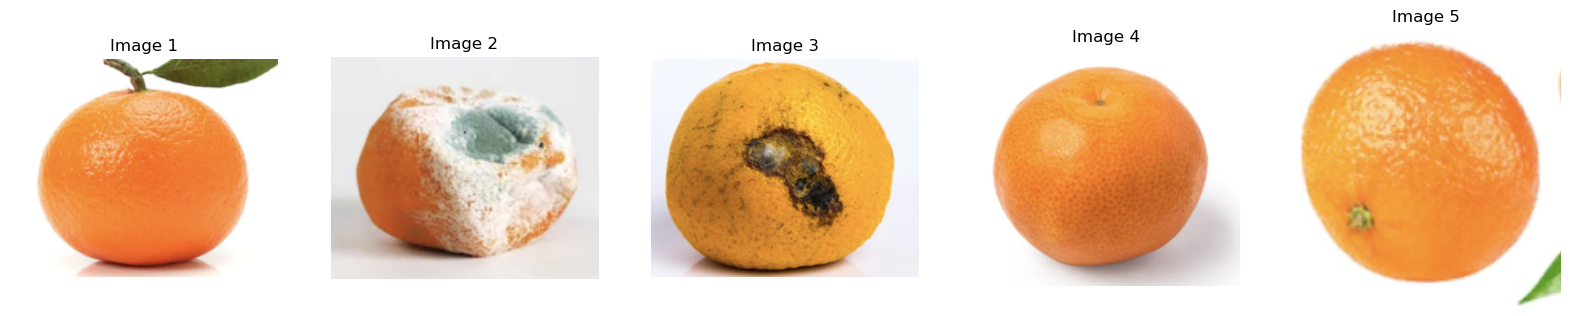

>>>>> End Showing Random Images <<<<<


In [29]:
images, filenames = show_random_images(dataset, seed_no=12)

In [30]:
image = cv2.imread(Path('./Orange/FreshOrange12.png').as_posix())
image.shape

(406, 460, 3)

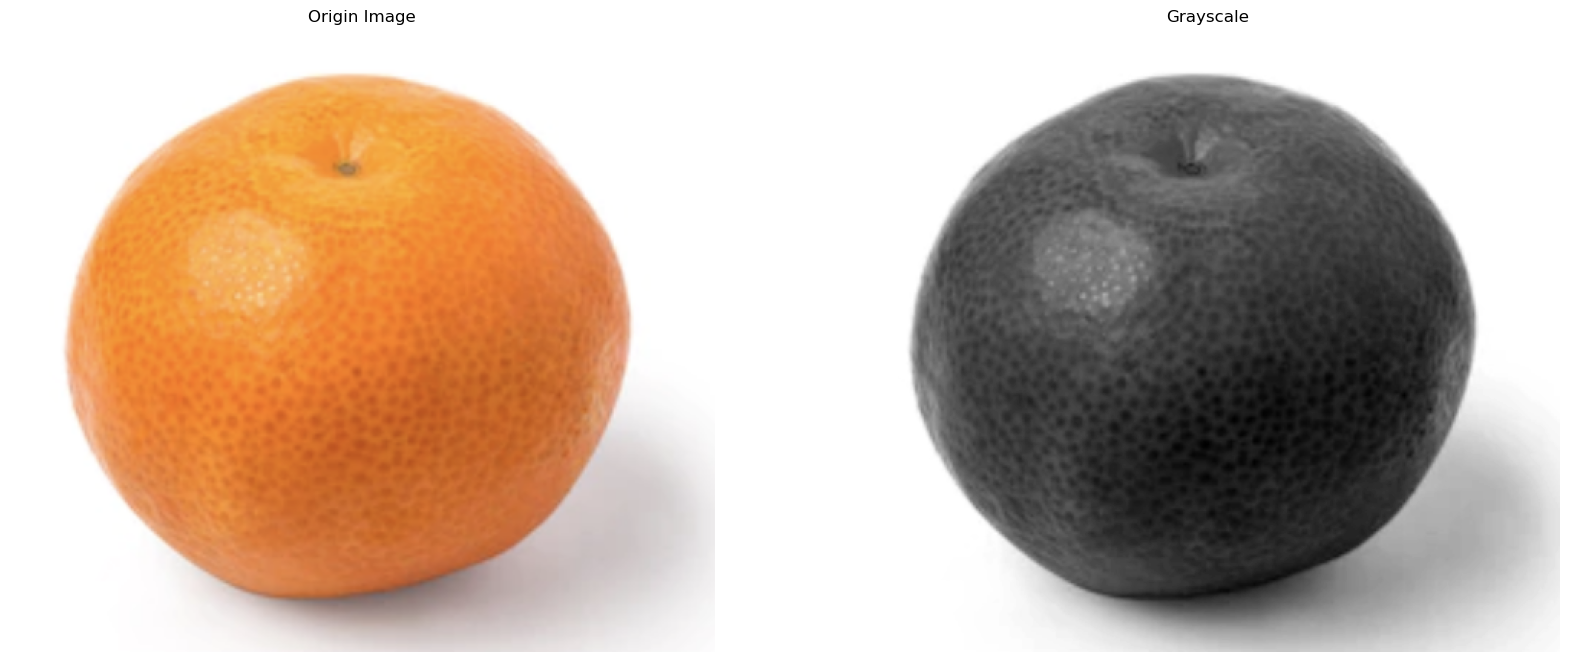

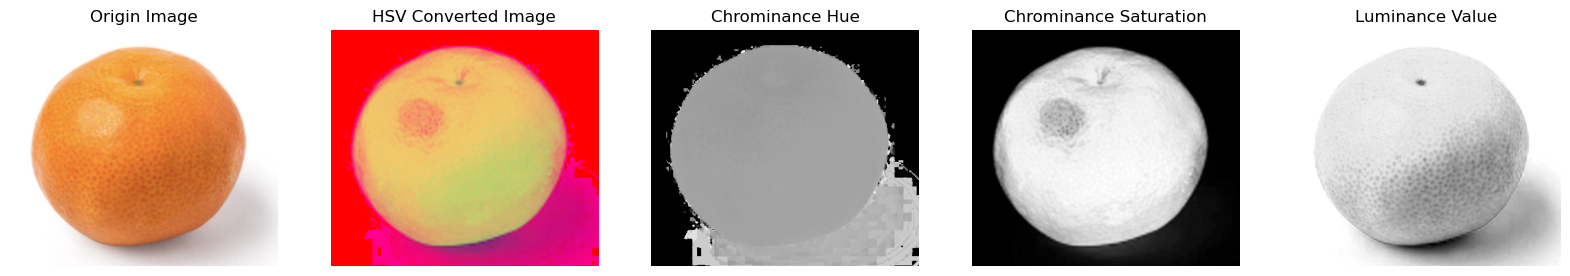

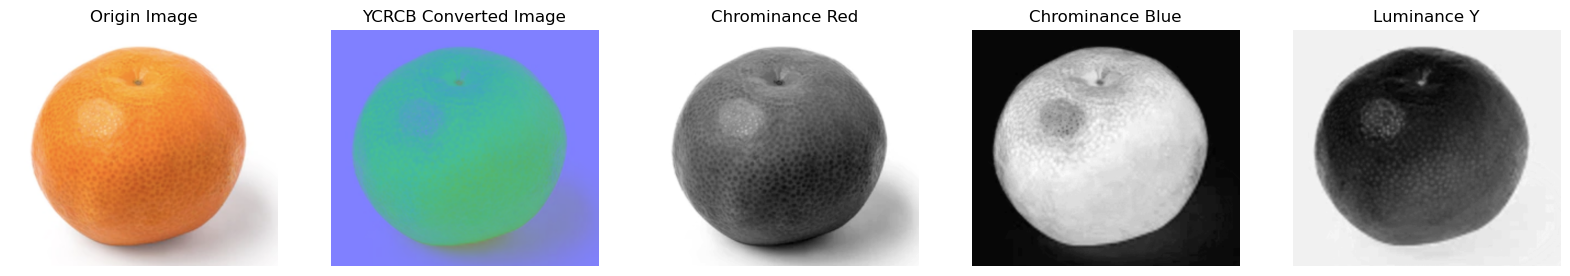

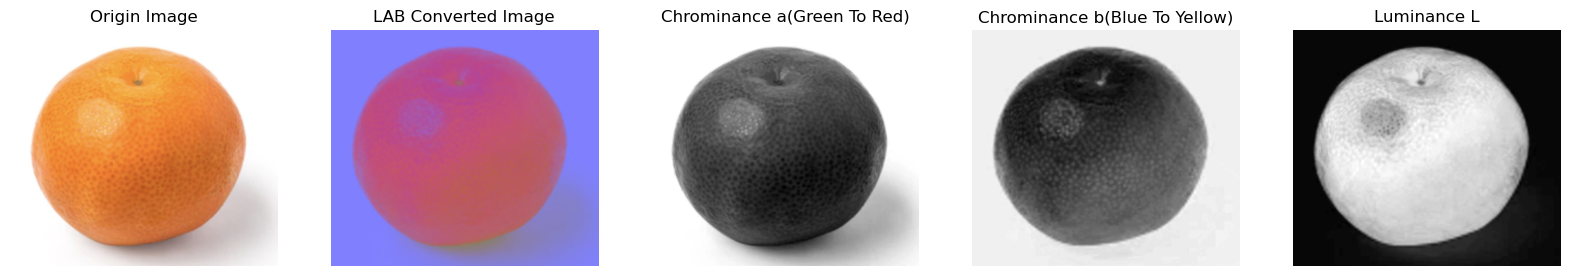

In [31]:
image_gray = convert_color_spaces(image, color_space="GRAY")
image_hsv = convert_color_spaces(image, color_space="HSV")
image_ycrcb = convert_color_spaces(image, color_space="YCrCb")
image_lab = convert_color_spaces(image, color_space="Lab")

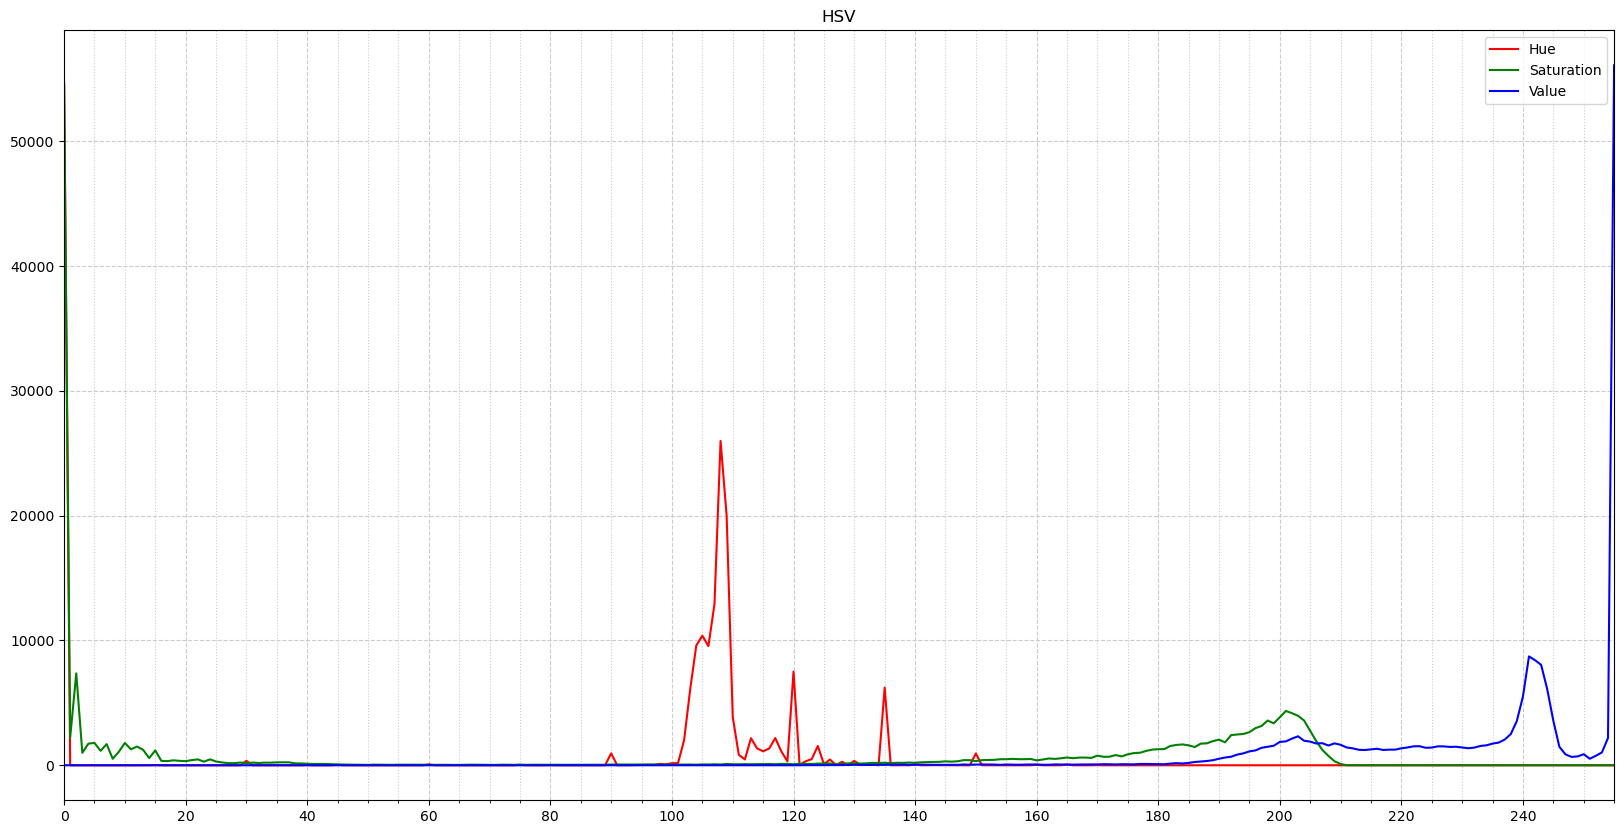

In [32]:
show_histogram(image_hsv, title="HSV", channel_list=["Hue", "Saturation", "Value"])

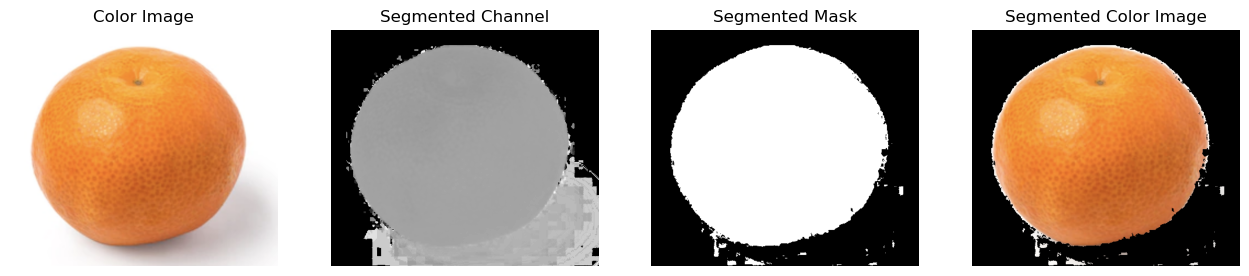

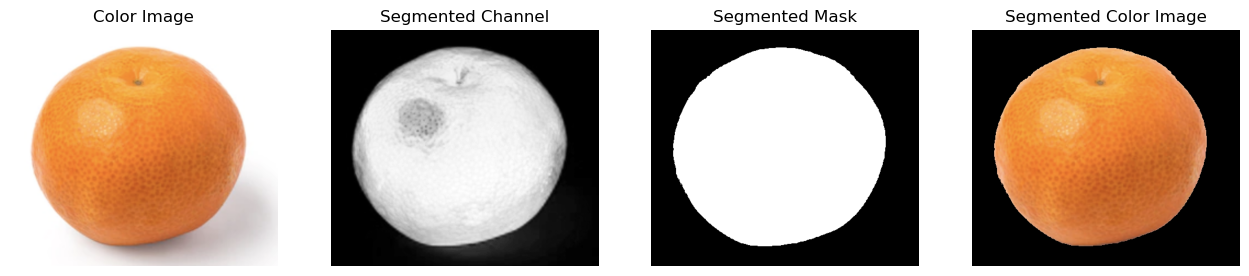

In [33]:
image_mask_bythresh1 = segment_by_thresh(image, channel=image_hsv[:, :, 0], segment_range=[90, 111], display=True)
image_mask_bythresh2 = segment_by_thresh(image, channel=image_hsv[:, :, 1], segment_range=[90, 240], display=True)


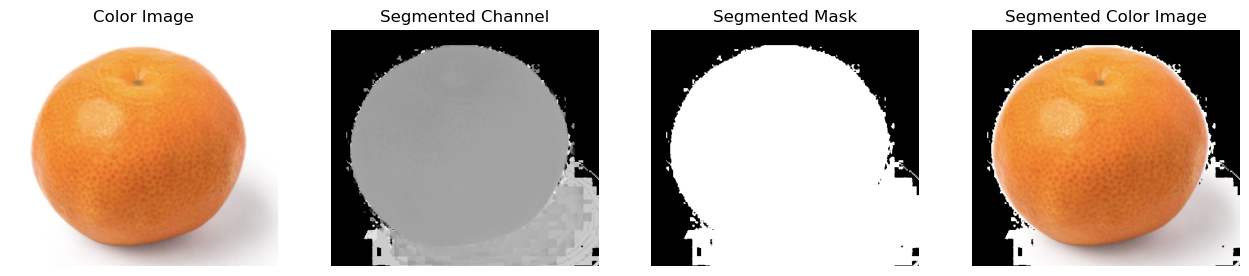

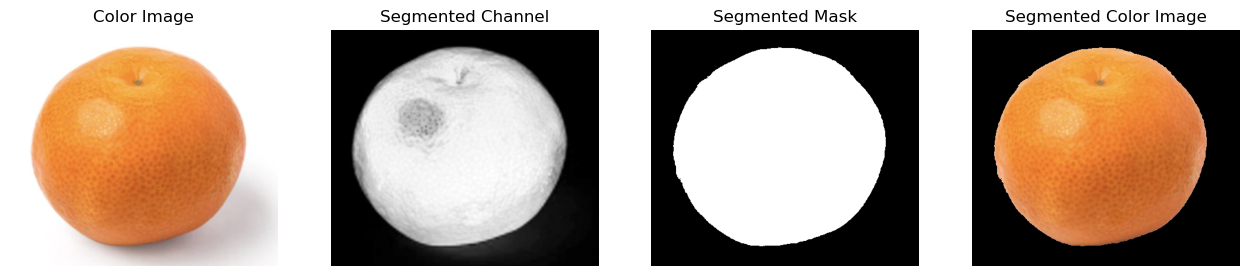

In [34]:
image_mask_byauto1 = segment_by_thresh(image, channel=image_hsv[:, :, 0])
image_mask_byauto2 = segment_by_thresh(image, channel=image_hsv[:, :, 1])


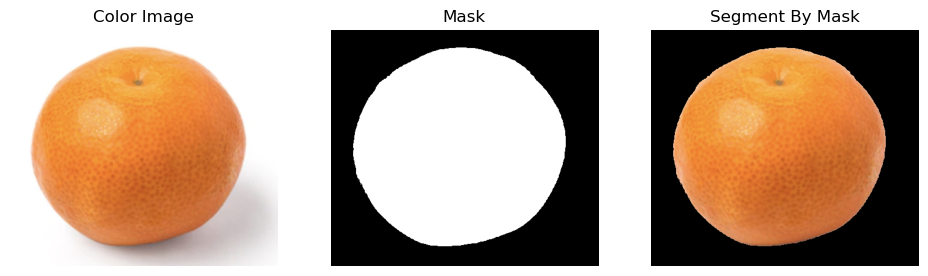

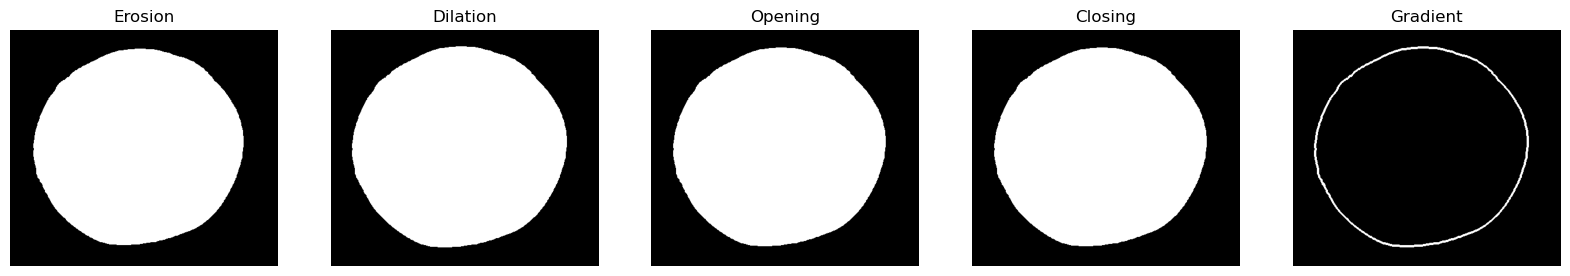

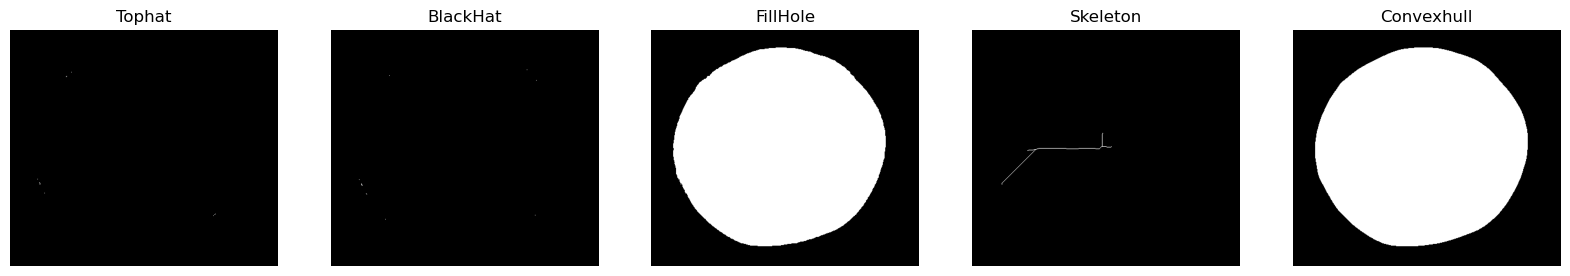

In [35]:
image_mask_bythresh = image_mask_bythresh2.copy()
image_mask_adjust = morphology(image, image_mask_bythresh, mor_type = "fillhole", size = 2)

In [36]:
def orange_mask_segment(image, image_mask, display=True):
    masks = [image_mask]
    image_mask_adjust = morphology(image, image_mask, mor_type = "erosion", size = 5, display=False)
    masks.append(image_mask_adjust)

    if display:
        show_images(masks, 1, 5, titles= ["Original", "Erosion"])
    return image_mask_adjust

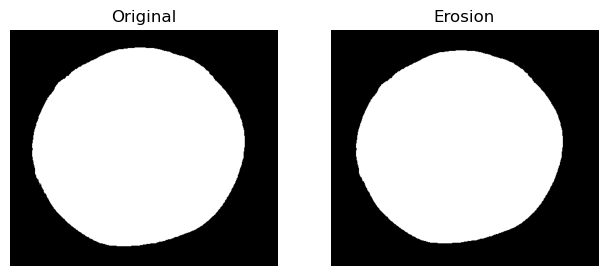

In [37]:
image_mask_adjust = orange_mask_segment(image, image_mask_bythresh, display=True)

_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/FreshOrange02.png __________
Already save results to None
None/FreshOrange02_mask.jpg
None/FreshOrange02_demo.jpg


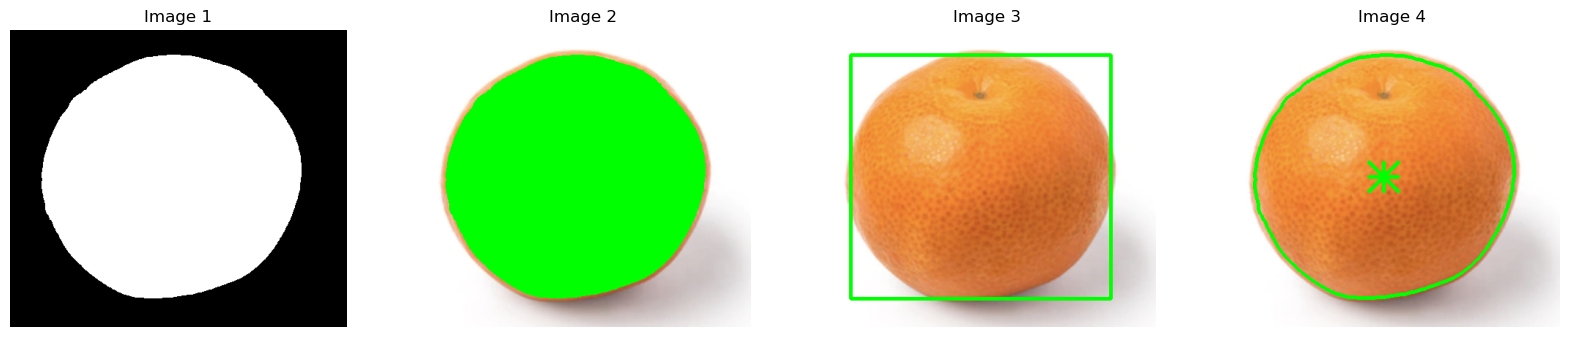

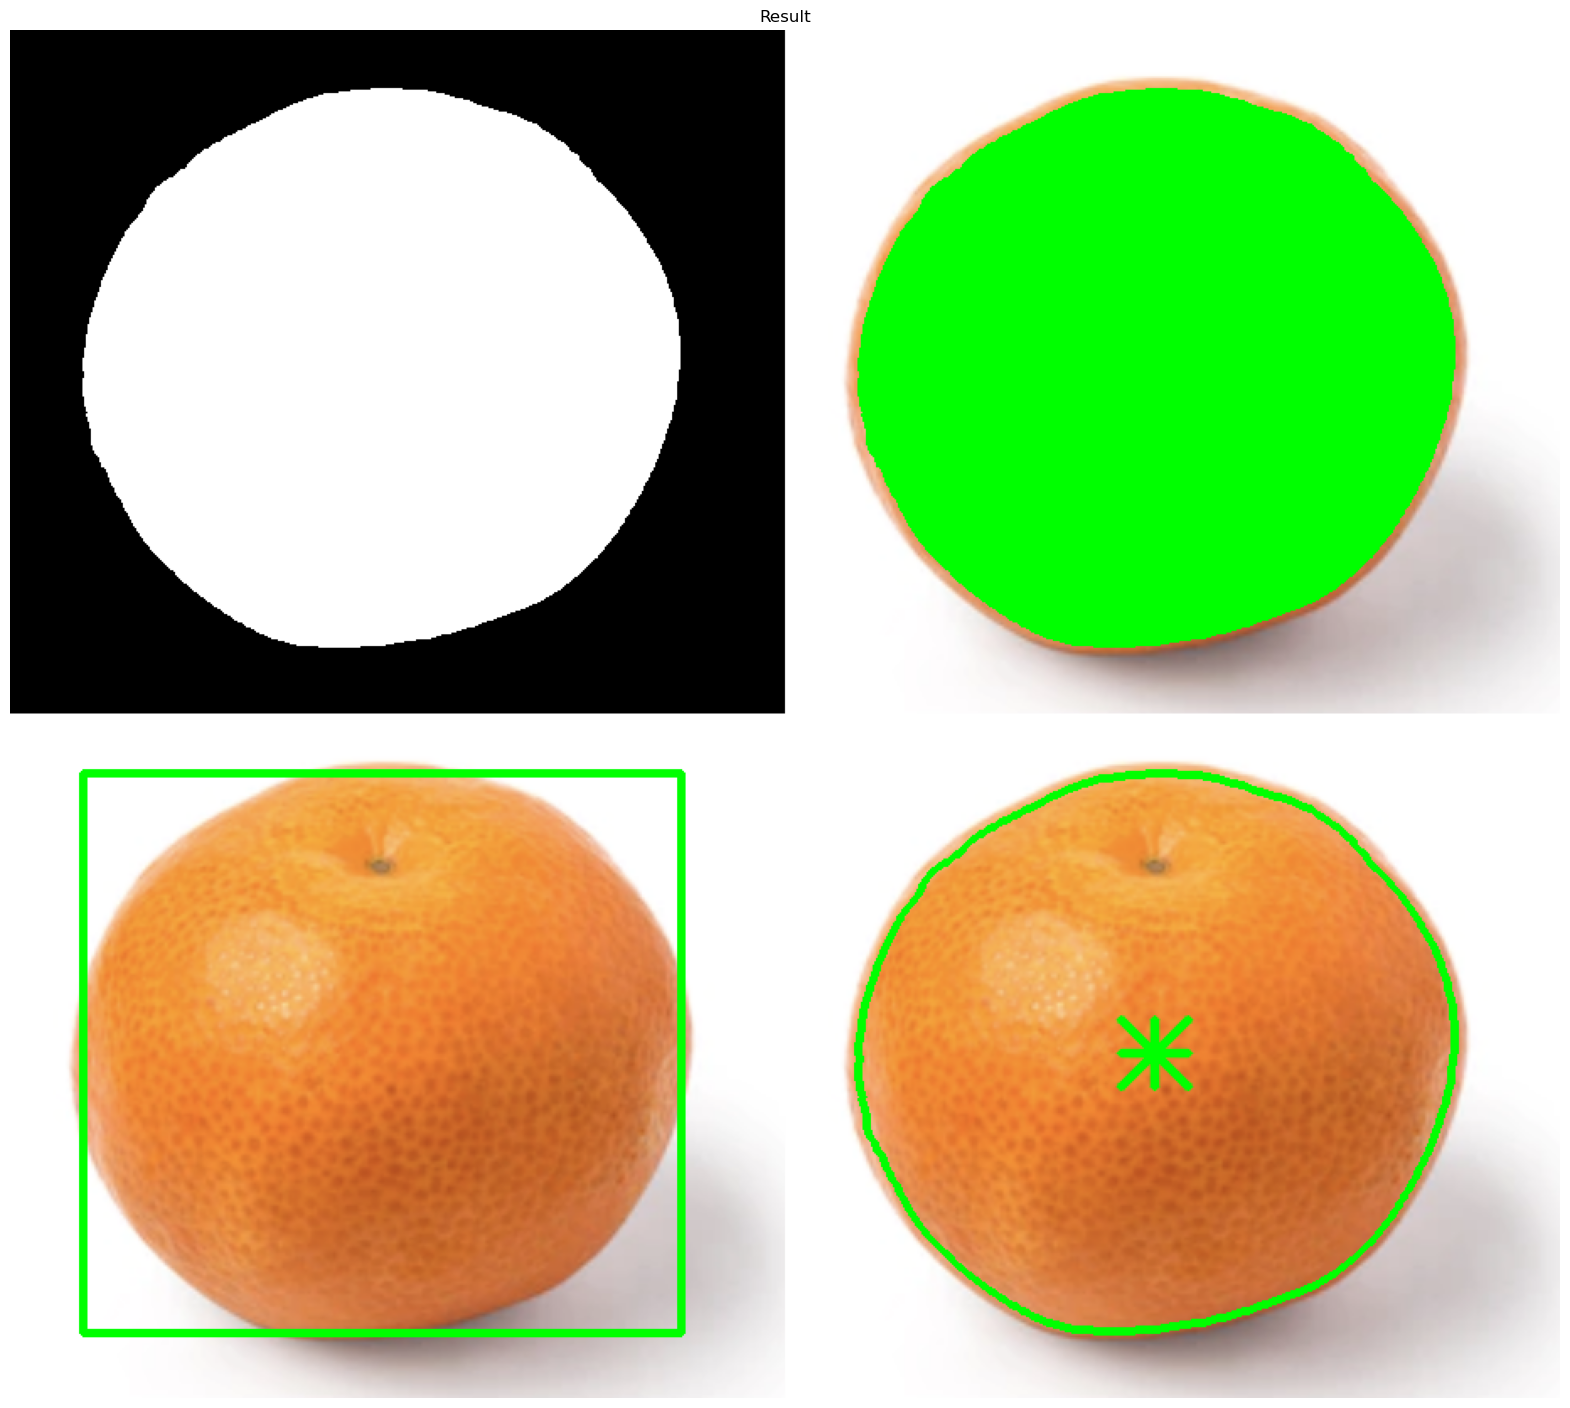

In [38]:
image_mask = image_mask_adjust.copy()
result = generate_output(image, image_mask, filepath=filenames[-1], savepath='None')

show_images(result[:-1], 1, 4)
show_images([result[-1]], 1, 1, titles= ["Result"])

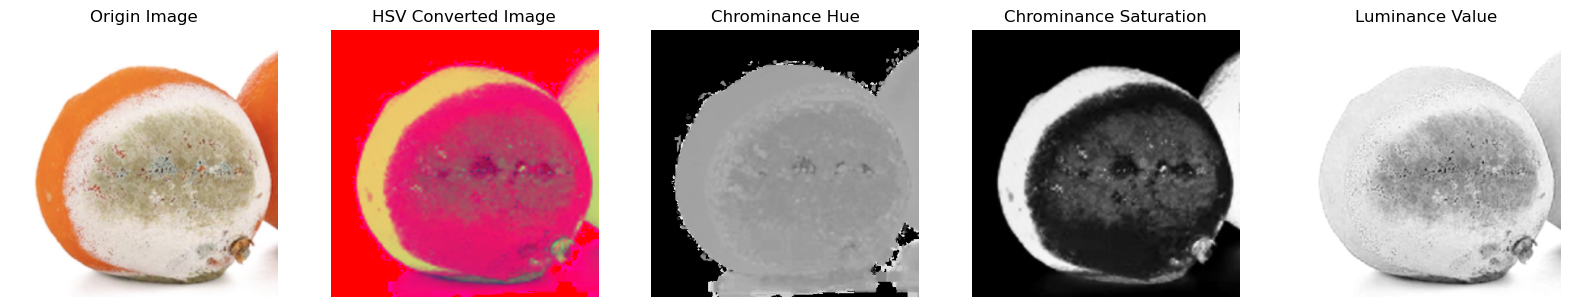

In [39]:
image = cv2.imread(Path("./Orange/RottenOrange20.png").as_posix())
image_hsv = convert_color_spaces(image, color_space="HSV", display=True)

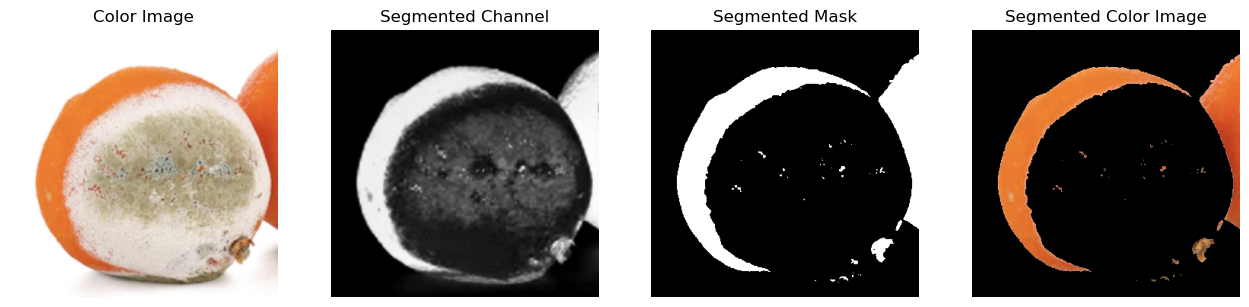

In [40]:
rotten_image_mask_bythresh = segment_by_thresh(image, channel=image_hsv[:, :, 1], display=True)

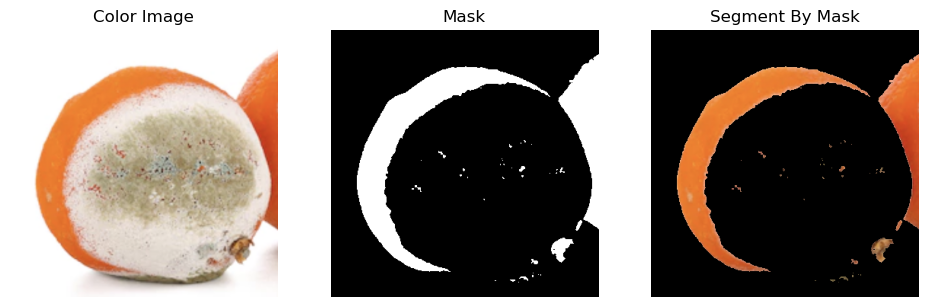

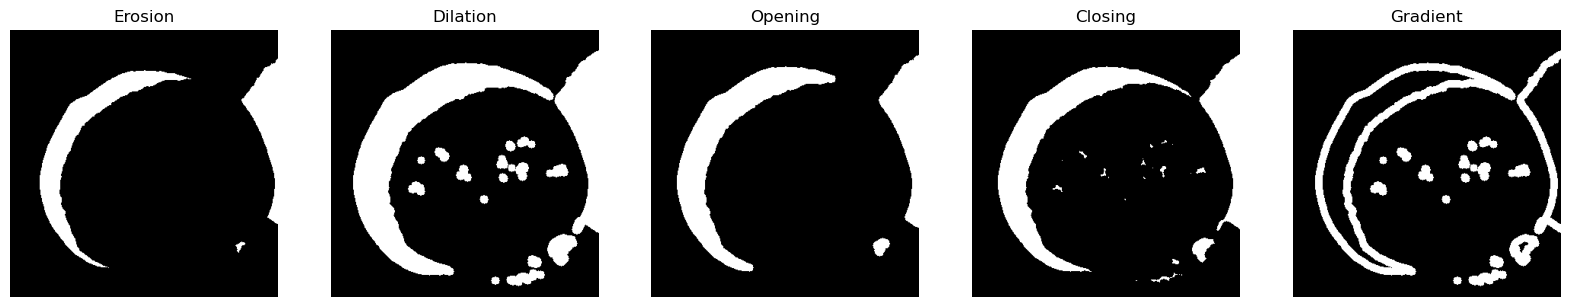

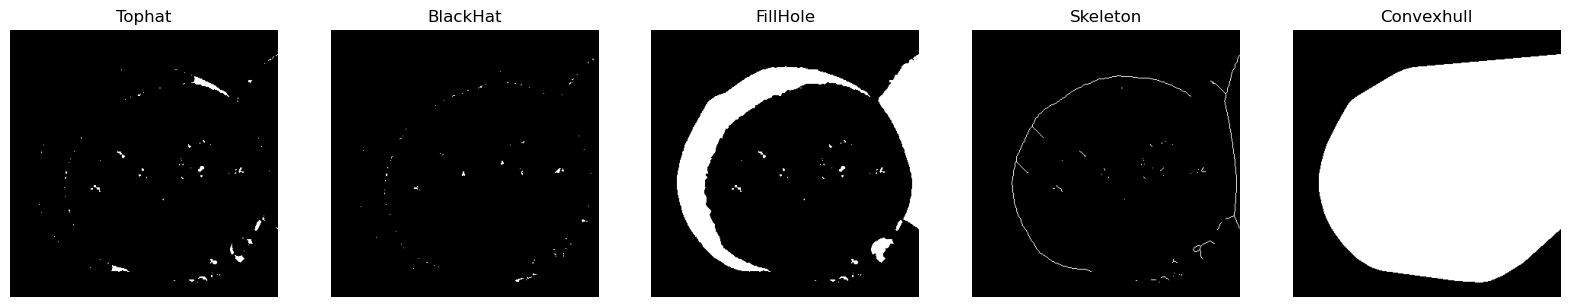

In [41]:
image_mask_adjust = morphology(image, rotten_image_mask_bythresh, mor_type = "open", size = 5, display=True)

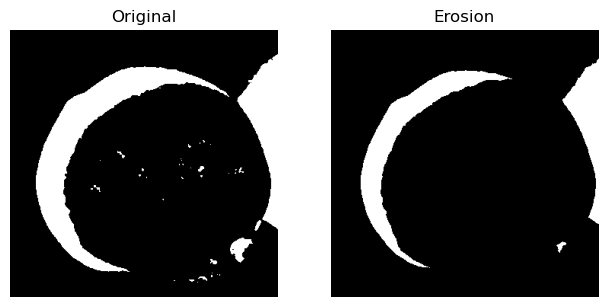

In [42]:
rotten_image_mask_adjust = orange_mask_segment(image, rotten_image_mask_bythresh, display=True)

_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/FreshOrange02.png __________
Already save results to None
None/FreshOrange02_mask.jpg
None/FreshOrange02_demo.jpg


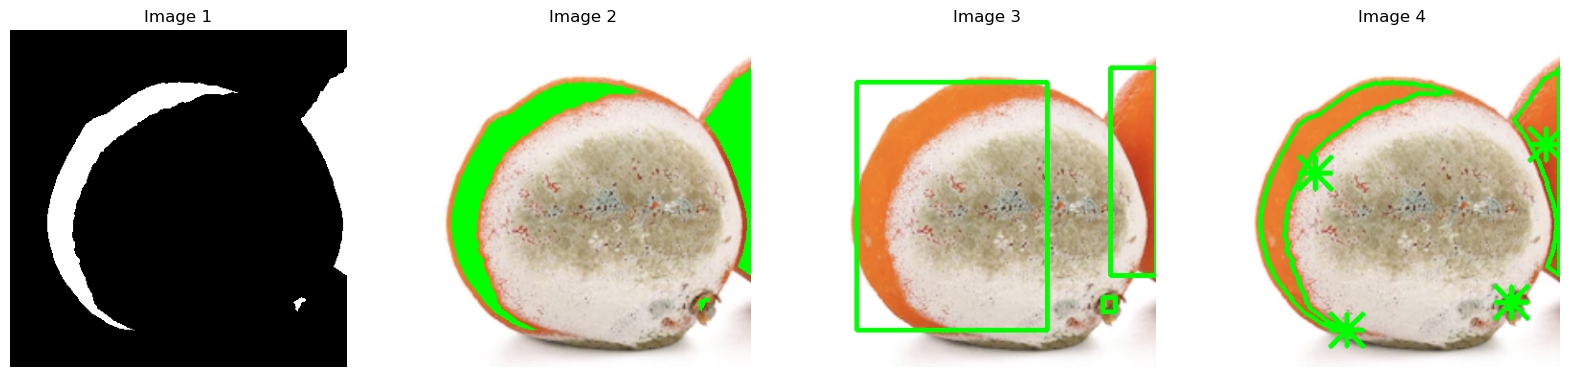

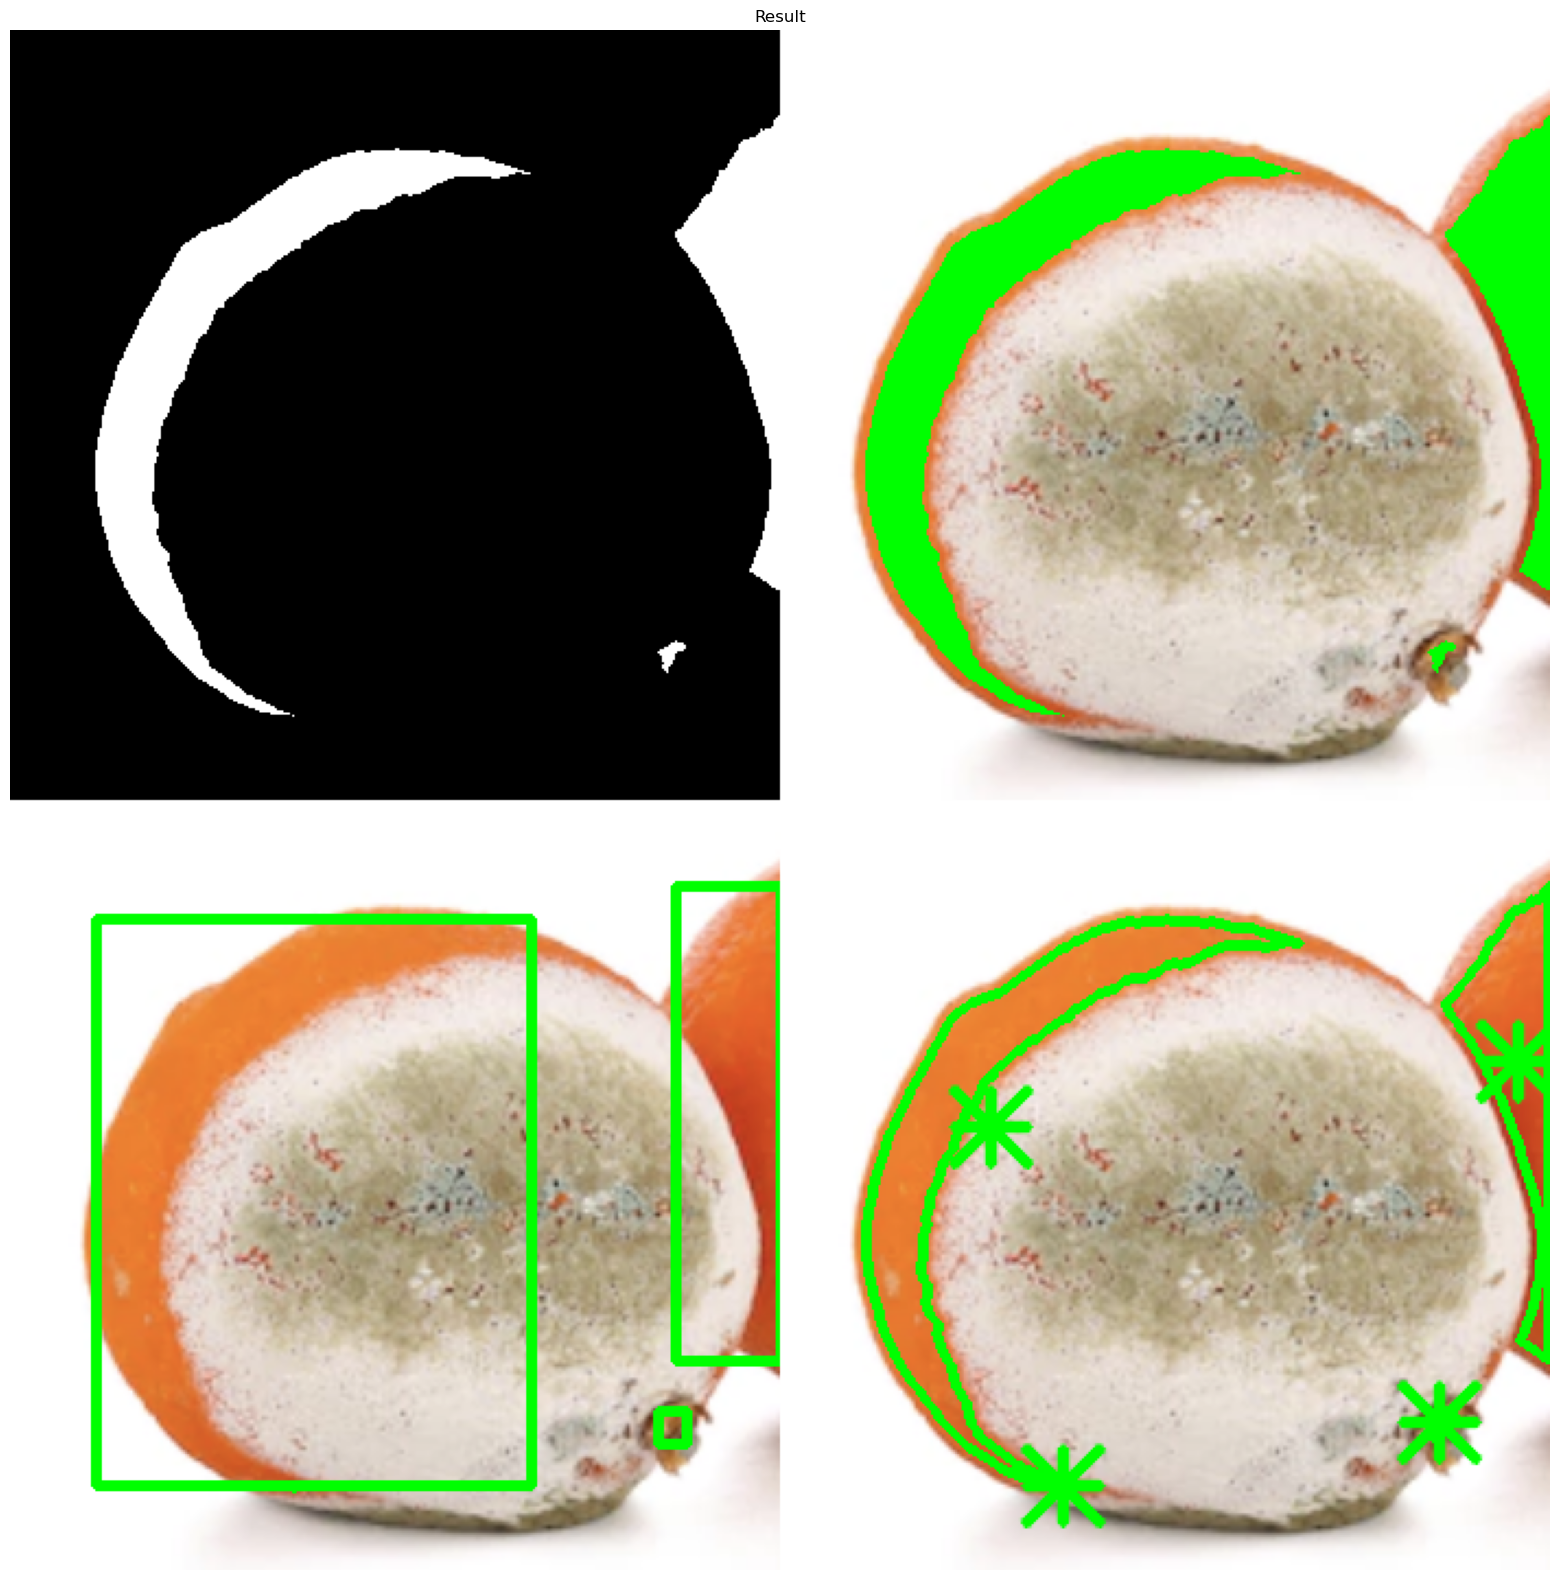

In [43]:
rotten_image_mask = rotten_image_mask_adjust.copy()
result = generate_output(image, rotten_image_mask, filepath=filenames[-1], savepath='None')

show_images(result[:-1], 1, 4)
show_images([result[-1]], 1, 1, titles= ["Result"])

In [44]:
try:
  os.makedirs(os.path.join(lab_path, 'Orange (Output)'))
except Exception as e:
  print(e)

[Errno 17] File exists: '/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange (Output)'


_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/FreshOrange06.png __________
Already save results to Orange (Output)
Orange (Output)/FreshOrange06_mask.jpg
Orange (Output)/FreshOrange06_demo.jpg


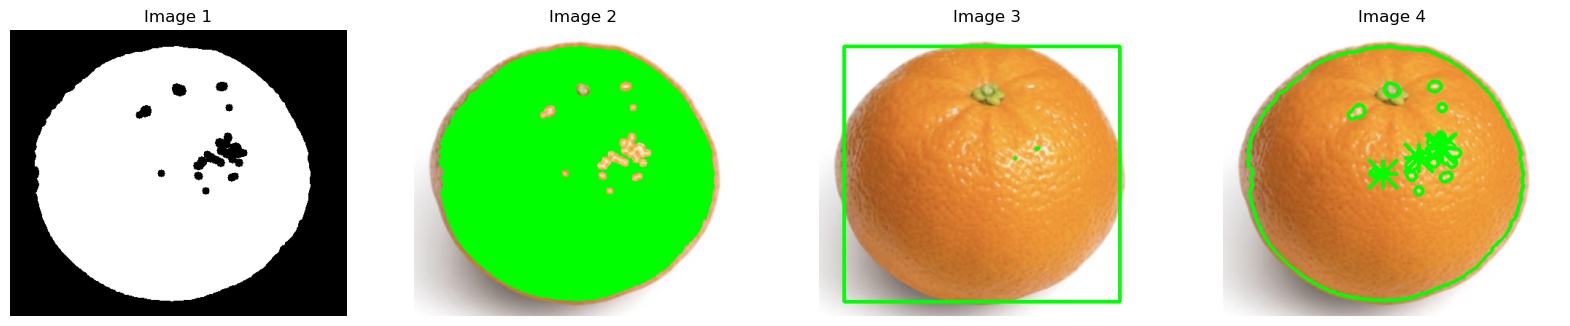

_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/FreshOrange19.png __________
Already save results to Orange (Output)
Orange (Output)/FreshOrange19_mask.jpg
Orange (Output)/FreshOrange19_demo.jpg


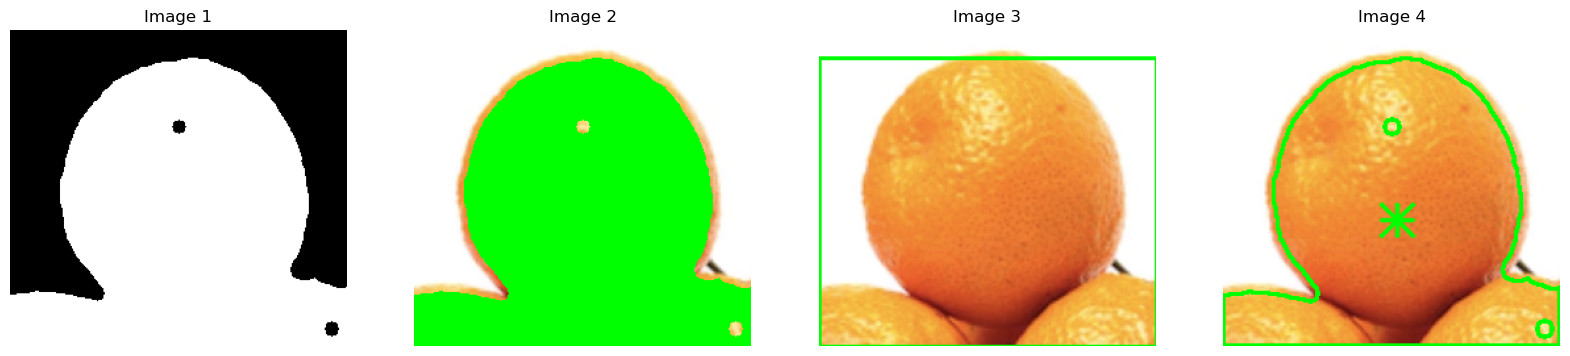

_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/RottenOrange17.png __________
Already save results to Orange (Output)
Orange (Output)/RottenOrange17_mask.jpg
Orange (Output)/RottenOrange17_demo.jpg


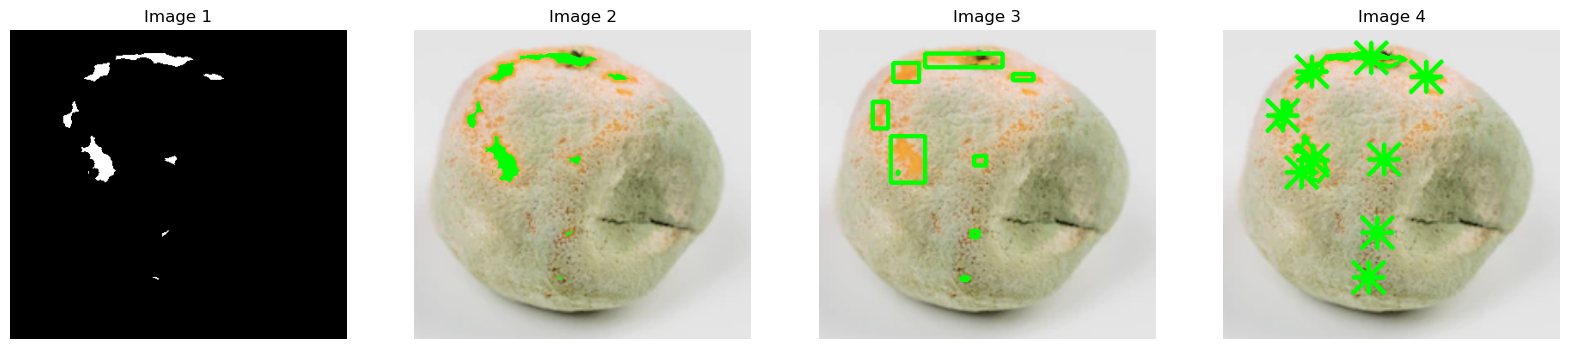

_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/RottenOrange03.png __________
Already save results to Orange (Output)
Orange (Output)/RottenOrange03_mask.jpg
Orange (Output)/RottenOrange03_demo.jpg


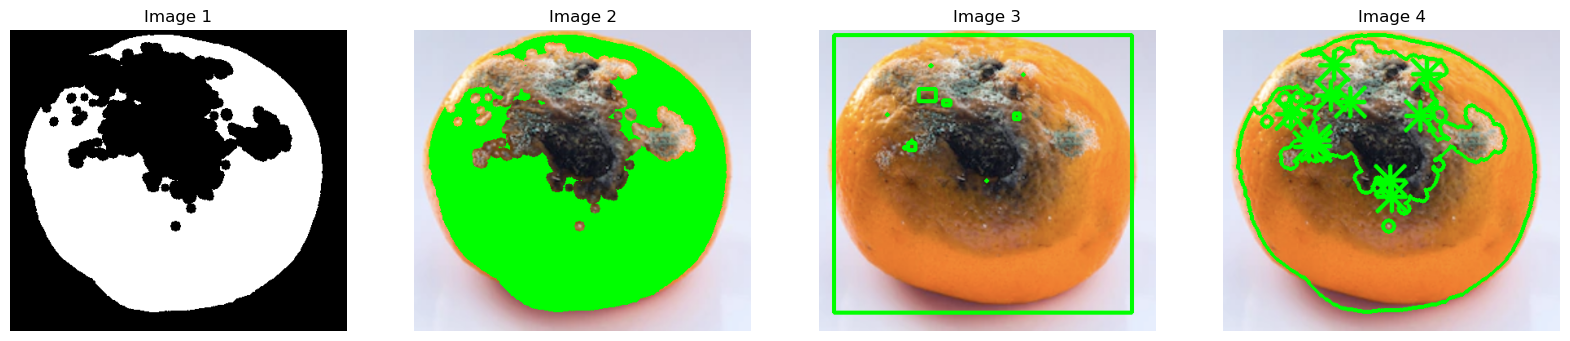

_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/RottenOrange14.png __________
Already save results to Orange (Output)
Orange (Output)/RottenOrange14_mask.jpg
Orange (Output)/RottenOrange14_demo.jpg


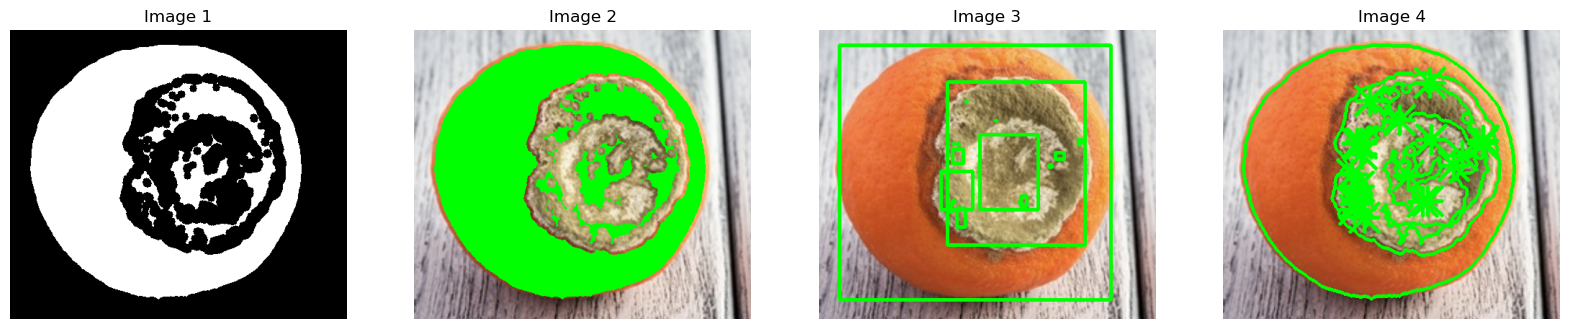

_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/RottenOrange16.png __________
Already save results to Orange (Output)
Orange (Output)/RottenOrange16_mask.jpg
Orange (Output)/RottenOrange16_demo.jpg


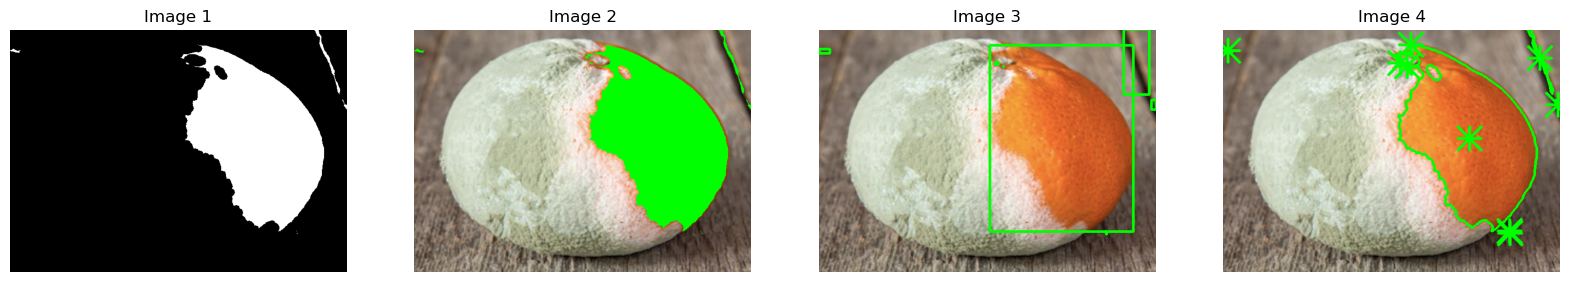

_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/RottenOrange09.png __________
Already save results to Orange (Output)
Orange (Output)/RottenOrange09_mask.jpg
Orange (Output)/RottenOrange09_demo.jpg
_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/FreshOrange07.png __________
Already save results to Orange (Output)
Orange (Output)/FreshOrange07_mask.jpg
Orange (Output)/FreshOrange07_demo.jpg


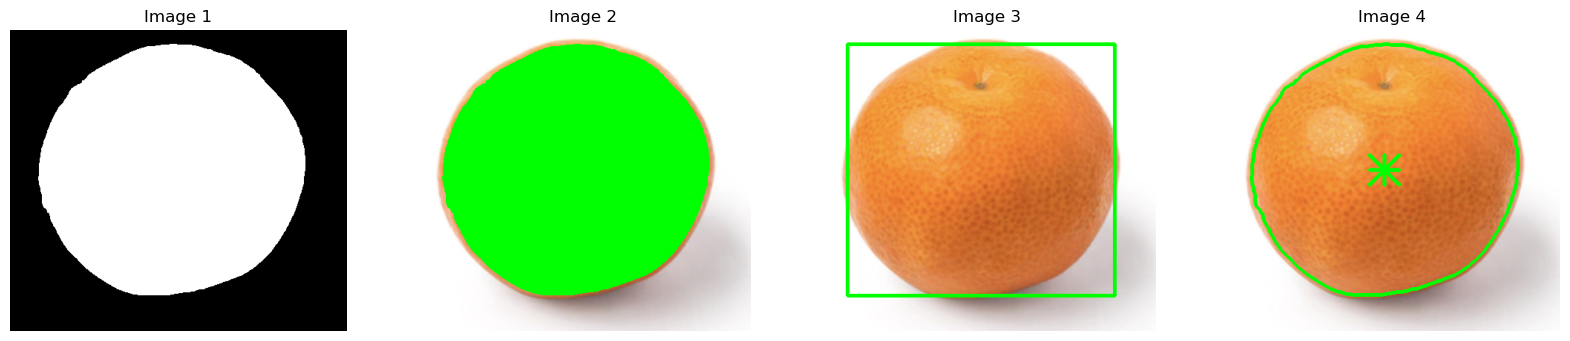

_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/FreshOrange12.png __________
Already save results to Orange (Output)
Orange (Output)/FreshOrange12_mask.jpg
Orange (Output)/FreshOrange12_demo.jpg


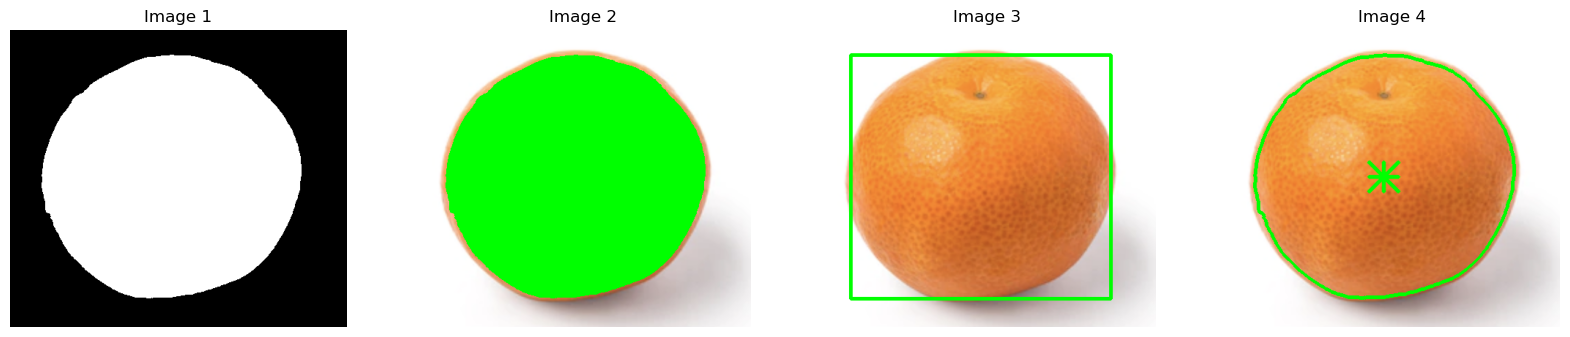

_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/RottenOrange20.png __________
Already save results to Orange (Output)
Orange (Output)/RottenOrange20_mask.jpg
Orange (Output)/RottenOrange20_demo.jpg


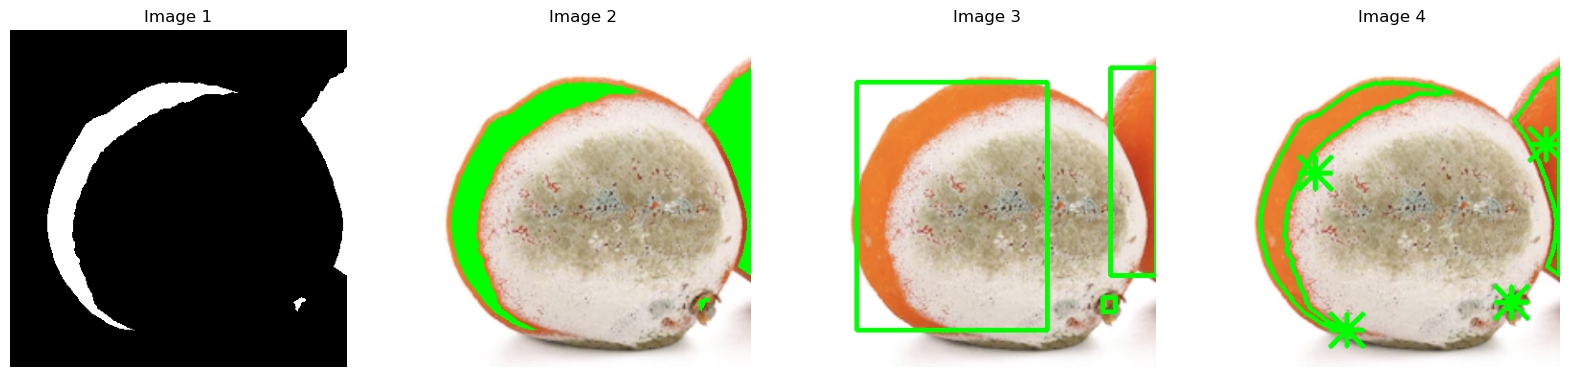

_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/FreshOrange16.png __________
Already save results to Orange (Output)
Orange (Output)/FreshOrange16_mask.jpg
Orange (Output)/FreshOrange16_demo.jpg


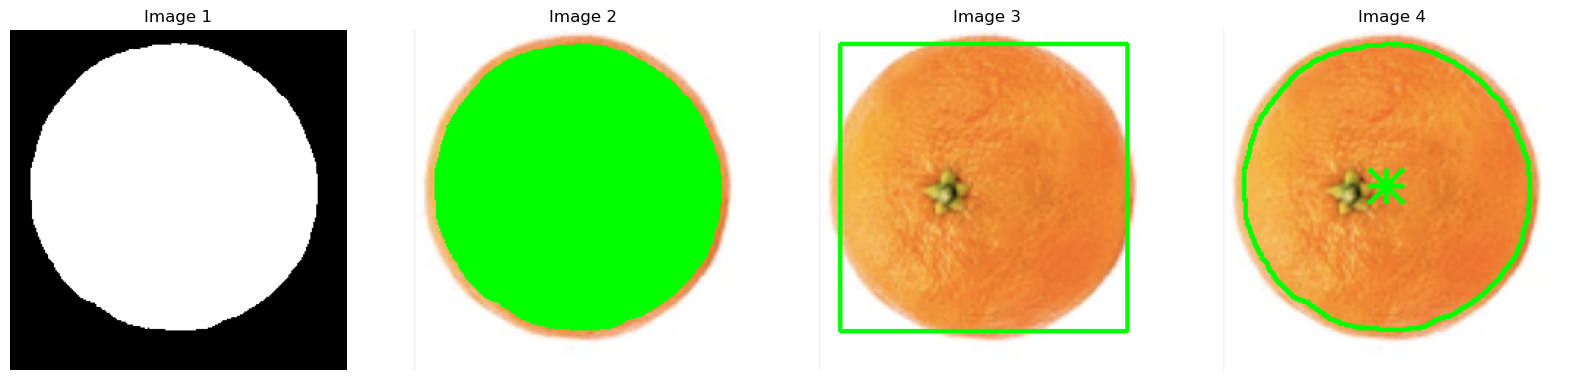

_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/RottenOrange15.png __________
Already save results to Orange (Output)
Orange (Output)/RottenOrange15_mask.jpg
Orange (Output)/RottenOrange15_demo.jpg


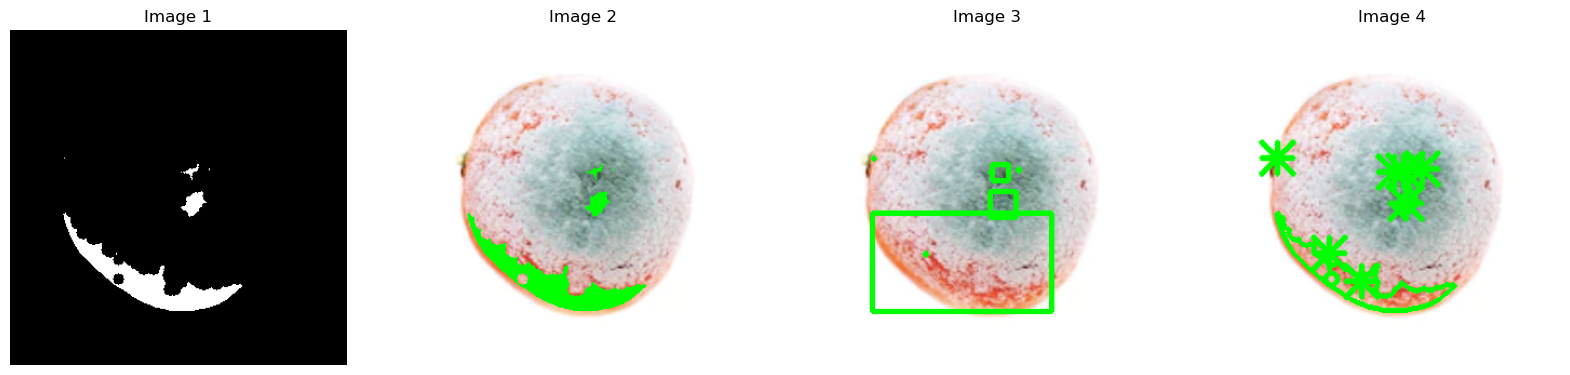

_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/FreshOrange17.png __________
Already save results to Orange (Output)
Orange (Output)/FreshOrange17_mask.jpg
Orange (Output)/FreshOrange17_demo.jpg


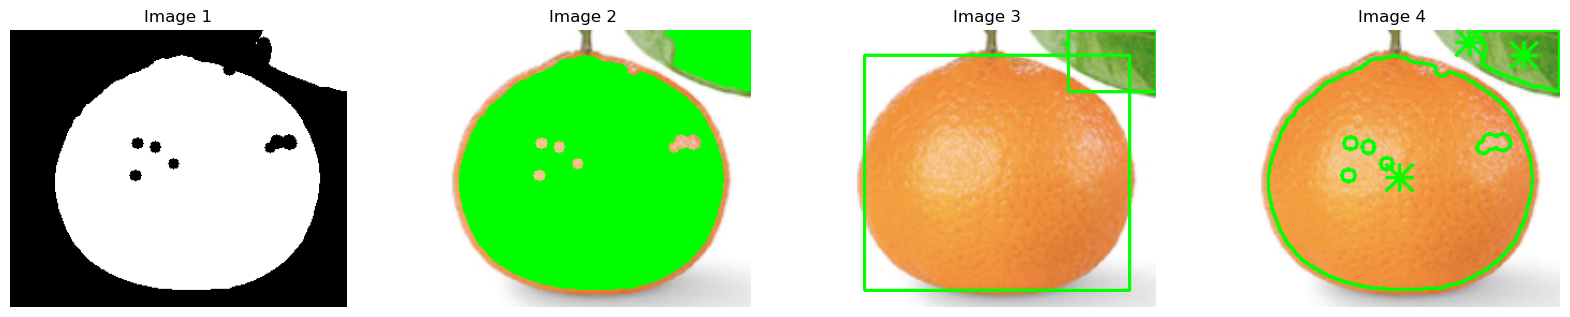

_________ /home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/FreshOrange03.png __________
Already save results to Orange (Output)
Orange (Output)/FreshOrange03_mask.jpg
Orange (Output)/FreshOrange03_demo.jpg


In [45]:
i = 0
for file in dataset[0:20]:
    image = cv2.imread(file)
    image_hsv = convert_color_spaces(image, color_space="HSV", display=False)
    image_mask_bythresh = segment_by_thresh(image, channel=image_hsv[:, :, 1], segment_range=[90, 240], display=False)
    image_mask_adjust = orange_mask_segment(image, image_mask_bythresh, display=False)
    result = generate_output(image, image_mask_adjust, filepath=file, savepath='Orange (Output)')
    if i <= 5:
        show_images(result[:-1], 1, 4)
        i += 1
    else:
      break

i = 0
for file in dataset[21:]:
    image = cv2.imread(file)
    image_hsv = convert_color_spaces(image, color_space="HSV", display=False)
    image_mask_bythresh = segment_by_thresh(image, channel=image_hsv[:, :, 1], display=False)
    image_mask_adjust = orange_mask_segment(image, image_mask_bythresh, display=False)
    result = generate_output(image, image_mask_adjust, filepath=file, savepath='Orange (Output)')
    if i <= 5:
        show_images(result[:-1], 1, 4)
        i += 1
    else:
      break

## 2/ Thực hiện trích các đặc trưng màu sắc, kích thước, hình dạng v.v… để thành lập 1 table có 2 lớp là fresh và rotten

In [46]:
pos_data = get_sub_files(os.path.join(lab_path, 'Orange', 'data', 'fresh'), ['.png'])
neg_data = get_sub_files(os.path.join(lab_path, 'Orange', 'data', 'rotten'), ['.png'])

dataset = pos_data + neg_data

>>>>> Begin Getting Sub Files <<<<<
There are 206 files are found
Here is some samples :
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/data/fresh/Screen Shot 2018-06-12 at 11.52.16 PM.png
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/data/fresh/Screen Shot 2018-06-13 at 12.17.05 AM.png
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/data/fresh/Screen Shot 2018-06-13 at 12.02.20 AM.png
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/data/fresh/Screen Shot 2018-06-12 at 11.55.28 PM.png
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/data/fresh/Screen Shot 2018-06-13 at 12.18.02 AM.png
>>>>> End Getting Sub Files <<<<<
>>>>> Begin Getting Sub Files <<<<<
There are 222 files are found
Here is some samples :
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/data/rotten/Screen Shot 2018-06-12 at 11.45.57 PM.png
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Orange/data/rotten/Screen Shot 2018-06-12 at 11.29.51 PM.png
/home/tqh/Worksp

In [47]:
try:
  os.makedirs(os.path.join(lab_path, 'Data (Output)'))
except Exception as e:
  print(e)

In [48]:
for file in tqdm(pos_data):
    image = cv2.imread(file)
    image_hsv = convert_color_spaces(image, color_space="HSV", display=False)
    image_mask_bythresh = segment_by_thresh(image, channel=image_hsv[:, :, 1], segment_range=[90, 240], display=False)
    image_mask_adjust = orange_mask_segment(image, image_mask_bythresh, display=False)
    result = generate_output(image, image_mask_adjust, filepath=file, savepath='Data (Output)',
                             save_demo=False, show_logging=False)


for file in tqdm(neg_data):
    image = cv2.imread(file)
    image_hsv = convert_color_spaces(image, color_space="HSV", display=False)
    image_mask_bythresh = segment_by_thresh(image, channel=image_hsv[:, :, 1], display=False)
    image_mask_adjust = orange_mask_segment(image, image_mask_bythresh, display=False)
    result = generate_output(image, image_mask_adjust, filepath=file, savepath='Data (Output)',
                             save_demo=False, show_logging=False)


  0%|          | 0/206 [00:00<?, ?it/s]

100%|██████████| 222/222 [00:09<00:00, 23.62it/s]


In [49]:
def get_json(dataset, positive=True):
    for file in tqdm(dataset):
        image = cv2.imread(file)

        gray = convert_color_spaces(image, color_space="gray", display=False)
        image_hsv = convert_color_spaces(image, color_space="HSV", display=False)

        filename = Path(file).stem
        image_mask = cv2.imread('Data (Output)/' + filename + '_mask.jpg')
        image_mask = image_mask[:, :, 0] > 200

        h, s, v = image_hsv[:, :, 0], image_hsv[:, :, 1], image_hsv[:, :, 2]

        visual_feature = {}
        try:
            center_point, center_contours = get_contour_center(image, image_mask, display=False)
            minor_len, major_len, orientation, bbox = get_major_minor_length(image, image_mask, display=False)
            area, perimeter, solidity, roundness = get_area_perimeter_solidity(image, image_mask, display=False)

            (min_h, max_h, mean_h, q1_h, q2_h, q3_h) = get_min_max_mean_quantile_intensity(image, image_mask, h, display=False)
            (min_s, max_s, mean_s, q1_s, q2_s, q3_s) = get_min_max_mean_quantile_intensity(image, image_mask, h, display=False)
            (min_v, max_v, mean_v, q1_v, q2_v, q3_v) = get_min_max_mean_quantile_intensity(image, image_mask, h, display=False)
        except Exception as e:
            continue

        list_of_features = [
            'filename',
            'center_point1',
            'center_point2',
            'minor_length',
            'major_length',
            'orientation',
            'bbox1',
            'bbox2',
            'bbox3',
            'bbox4',
            'area',
            'perimeter',
            'solidity',
            'roundness',
            'intensity_min_hue',
            'intensity_max_hue',
            'intensity_mean_hue',
            'intensity_q1_hue',
            'intensity_q2_hue',
            'intensity_q3_hue',
            'intensity_min_saturation',
            'intensity_max_saturation',
            'intensity_mean_saturation',
            'intensity_q1_saturation',
            'intensity_q2_saturation',
            'intensity_q3_saturation',
            'intensity_min_value',
            'intensity_max_value',
            'intensity_mean_value',
            'intensity_q1_value',
            'intensity_q2_value',
            'intensity_q3_value',
        ]
        list_of_value = [
            filename,
            center_point[0],
            center_point[1],
            minor_len,
            major_len,
            orientation,
            bbox[0],
            bbox[1],
            bbox[2],
            bbox[3],
            area,
            perimeter,
            solidity,
            roundness,
            min_h,
            max_h,
            mean_h,
            q1_h,
            q2_h,
            q3_h,
            min_s,
            max_s,
            mean_s,
            q1_s,
            q2_s,
            q3_s,
            min_v,
            max_v,
            mean_v,
            q1_v,
            q2_v,
            q3_v
        ]
        if positive:
            visual_feature['label'] = str(1)
        else:
            visual_feature['label'] = str(0)

        for feature, value in zip(list_of_features, list_of_value):
            visual_feature[feature] = str(value)

        for i, contour in enumerate(center_contours):
            for j in range(len(contour)):
                visual_feature[f'center_contours_{i+1}_{j+1}'] = str(center_contours[i][j])

        write_json(filename, visual_feature, savepath='./Data (Output)')

In [50]:
get_json(pos_data)
get_json(neg_data, positive=False)

100%|██████████| 222/222 [00:20<00:00, 10.67it/s]


## 3/ Áp dụng 1 thuật toán MLs để học và phân loại giữa trái cam fresh và rotten

In [51]:
import sklearn
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, \
    f1_score, accuracy_score, precision_score, recall_score

In [52]:
jsons = get_sub_files(os.path.join(lab_path, 'Data (Output)'), ['.json'])

data_list = []

for json_file in jsons:
    row = pd.read_json(json_file, orient='index').transpose()
    data_list.append(row)

df = pd.concat(data_list, ignore_index=True)

>>>>> Begin Getting Sub Files <<<<<
There are 428 files are found
Here is some samples :
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Data (Output)/Screen Shot 2018-06-13 at 12.14.32 AM.json
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Data (Output)/Screen Shot 2018-06-13 at 12.17.31 AM.json
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Data (Output)/Screen Shot 2018-06-12 at 11.32.04 PM.json
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Data (Output)/Screen Shot 2018-06-12 at 11.28.33 PM.json
/home/tqh/Workspace/HCMUS/N3/K2/BHXLA-HCMUS/Lab02/Data (Output)/Screen Shot 2018-06-13 at 12.16.33 AM.json
>>>>> End Getting Sub Files <<<<<


In [53]:
df.drop(['filename'], axis=1, inplace=True)

In [54]:
df.dropna(inplace=True, axis=1)

In [55]:
df.astype('float32')

label  center_point1  center_point2  minor_length  major_length  \
0      1.0           84.0           89.0    135.142578    137.199265   
1      1.0          102.0          118.0    144.054428    209.772995   
2      0.0          127.0          107.0    189.688858    398.989044   
3      0.0          119.0          181.0    215.214859    284.210297   
4      1.0          190.0          198.0    333.864532    363.961487   
..     ...            ...            ...           ...           ...   
423    0.0          274.0          202.0    188.816299    364.565125   
424    1.0          190.0          230.0    352.059357    374.189056   
425    0.0           83.0           86.0    124.022957    138.898254   
426    1.0          183.0          195.0    306.459473    348.451355   
427    0.0          244.0          222.0    448.290558    496.770569   

     orientation  bbox1  bbox2  bbox3  bbox4  ...  intensity_q2_saturation  \
0       1.440822   13.0   22.0  160.0  160.0  ...                    105.0   
1      -1.361851   28.0   19.0  180.0  218.0  ...                    104.0   
2      -0.537140    0.0   11.0  406.0  321.0  ...                    105.0   
3      -1.174552    0.0   58.0  243.0  318.0  ...                    107.0   
4       1.251558   18.0   32.0  345.0  376.0  ...                    107.0   
..           ...    ...    ...    ...    ...  ...                      ...   
423     1.269987  147.0   56.0  374.0  388.0  ...                    110.0   
424    -1.193716   14.0   45.0  374.0  417.0  ...                    106.0   
425     0.464381   17.0   25.0  152.0  156.0  ...                    106.0   
426     0.710741   25.0   24.0  386.0  355.0  ...                    106.0   
427     1.490985   41.0   46.0  438.0  454.0  ...                    106.0   

     intensity_q3_saturation  intensity_min_value  intensity_max_value  \
0                      108.0                  8.0                117.0   
1                      105.0                 99.0                113.0   
2                      106.0                101.0                114.0   
3                      109.0                 82.0                120.0   
4                      108.0                 98.0                115.0   
..                       ...                  ...                  ...   
423                    111.0                 99.0                120.0   
424                    107.0                 78.0                116.0   
425                    107.0                 99.0                118.0   
426                    108.0                 82.0                118.0   
427                    107.0                 93.0                114.0   

     intensity_mean_value  intensity_q1_value  intensity_q2_value  \
0              102.031410               103.0               105.0   
1              104.684631               104.0               104.0   
2              104.935455               104.0               105.0   
3              105.357994               105.0               107.0   
4              106.536560               105.0               107.0   
..                    ...                 ...                 ...   
423            109.701782               109.0               110.0   
424            105.385963               104.0               106.0   
425            105.622711               104.0               106.0   
426            106.114510               105.0               106.0   
427            106.184074               105.0               106.0   

     intensity_q3_value  center_contours_1_1  center_contours_1_2  
0                 108.0                  1.0                 93.0  
1                 105.0                153.0                 28.0  
2                 106.0                271.0                409.0  
3                 109.0                317.0                  0.0  
4                 108.0                185.0                 18.0  
..                  ...                  ...                  ...  
423      

In [56]:
df.drop_duplicates(inplace=True)

In [57]:
df.shape

(428, 34)

In [58]:
features = [feature for feature in df.columns if feature not in ['filename', 'label']]
X = df[features]
y = df.label

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [60]:
logreg = LogisticRegression(random_state=24)
logreg.fit(X_train, y_train)

/home/tqh/anaconda3/envs/bhxla/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=24)

In [61]:
param_dict = {
    'n_estimators': np.arange(50, 200),
    'max_depth': np.arange(1, 10),
}

rf = RandomForestClassifier(random_state=24)
rand_search = RandomizedSearchCV(rf, param_dict, cv=5, random_state=24)
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=24),
                   param_distributions={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110,...
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199])},
                   random_state=24)

In [62]:
best_rf = rand_search.best_estimator_
print('Best hyperparameters:', rand_search.best_params_)
best_rf.fit(X_train, y_train)

Best hyperparameters: {'n_estimators': 153, 'max_depth': 8}


RandomForestClassifier(max_depth=8, n_estimators=153, random_state=24)

In [63]:
log_y_pred = logreg.predict(X_test)
rf_y_pred = best_rf.predict(X_test)
print(f'LogisticRegression: {log_y_pred}')
print(f'RandomForestClassifier: {rf_y_pred}')

LogisticRegression: ['0' '1' '0' '0' '1' '0' '0' '1' '1' '1' '0' '1' '1' '0' '1' '0' '1' '0'
 '0' '1' '1' '1' '0' '0' '0' '1' '1' '0' '1' '0' '0' '1' '0' '0' '1' '0'
 '0' '1' '1' '1' '1' '0' '1' '0' '1' '0' '0' '1' '0' '0' '0' '0' '0' '0'
 '1' '0' '0' '1' '0' '1' '1' '1' '0' '0' '0' '1' '1' '0' '0' '1' '0' '0'
 '0' '0' '1' '0' '1' '0' '0' '0' '0' '1' '0' '1' '1' '1']
RandomForestClassifier: ['0' '1' '0' '0' '1' '0' '1' '1' '1' '1' '0' '1' '1' '0' '0' '0' '1' '0'
 '0' '1' '1' '1' '0' '0' '0' '1' '1' '1' '1' '0' '0' '1' '0' '0' '1' '0'
 '0' '1' '0' '1' '1' '0' '1' '0' '0' '0' '0' '1' '0' '0' '0' '0' '0' '1'
 '1' '0' '0' '1' '0' '1' '0' '0' '0' '1' '0' '0' '1' '0' '0' '0' '0' '0'
 '0' '0' '1' '0' '0' '0' '0' '1' '0' '1' '0' '1' '1' '0']


Text(0.5, 427.9555555555555, 'Predicted label')

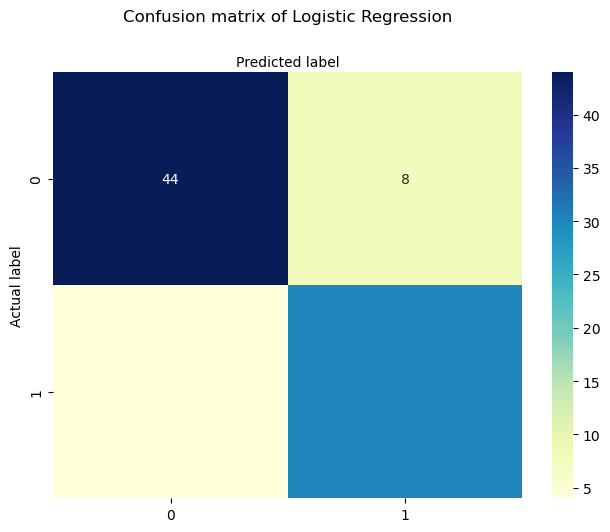

In [73]:
cnf_matrix = confusion_matrix(y_test, log_y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix of Logistic Regression', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 427.9555555555555, 'Predicted label')

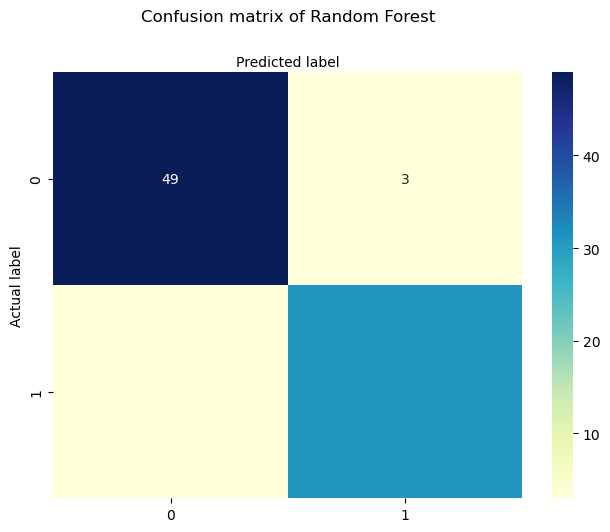

In [74]:
cnf_matrix = confusion_matrix(y_test, rf_y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix of Random Forest', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [75]:
y_test = np.array(y_test)
print('_____Logistic Regression______')
print("Accuracy:", accuracy_score(y_test, log_y_pred))
print("Precision:", precision_score(y_test, log_y_pred, average='weighted'))
print("Recall:", recall_score(y_test, log_y_pred, average='weighted'))
print("F1:", f1_score(y_test, log_y_pred, average='weighted'))

_____Logistic Regression______
Accuracy: 0.8604651162790697
Precision: 0.8663810689514484
Recall: 0.8604651162790697
F1: 0.8615503875968991


In [76]:
print('_____Random Forest______')
print("Accuracy:", accuracy_score(y_test, rf_y_pred))
print("Precision:", precision_score(y_test, rf_y_pred, average='weighted'))
print("Recall:", recall_score(y_test, rf_y_pred, average='weighted'))
print("F1:", f1_score(y_test, rf_y_pred, average='weighted'))

_____Random Forest______
Accuracy: 0.9302325581395349
Precision: 0.9302325581395349
Recall: 0.9302325581395349
F1: 0.9302325581395349


In [77]:
target_names = ['rotten, 0', 'fresh, 1']
print('_______________Logistic Regression_________________')
print(classification_report(y_test, log_y_pred, target_names=target_names))
print('_______________Random Forest_______________________')
print(classification_report(y_test, rf_y_pred, target_names=target_names))

_______________Logistic Regression_________________
              precision    recall  f1-score   support

   rotten, 0       0.92      0.85      0.88        52
    fresh, 1       0.79      0.88      0.83        34

    accuracy                           0.86        86
   macro avg       0.85      0.86      0.86        86
weighted avg       0.87      0.86      0.86        86

_______________Random Forest_______________________
              precision    recall  f1-score   support

   rotten, 0       0.94      0.94      0.94        52
    fresh, 1       0.91      0.91      0.91        34

    accuracy                           0.93        86
   macro avg       0.93      0.93      0.93        86
weighted avg       0.93      0.93      0.93        86

